##### Summary of the Paper - https://doi.org/10.1371/journal.pone.0308045
The paper proposes a method to improve human activity classification using micro-Doppler (m-D) signatures from FMCW radar. Key contributions include:

Denoising Algorithm: It is a two step algorithm -

* Step 1: Determine the optimal range-bin interval using minimum entropy to focus on relevant signal regions.

* Step 2: Apply a cut-threshold to remove noise from the STFT of selected range-bins.

Cross-Residual CNN (CRCNN): A lightweight CNN with cross-residual connections and multi-scale filters to enhance feature extraction from denoised spectrograms.

The model achieves 99% accuracy at -10 dB SNR after denoising.

In [159]:
# import libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io
from scipy.signal import stft
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

In [160]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Huy/ECE613_new')
file_path = os.getcwd() + '/W/W/3m_0_file60.mat'
def load_radar_data(file_path):
    """Load radar data from .mat file."""
    data = scipy.io.loadmat(file_path)
    signal_data = data['received_time_domain_signal']  # Shape: (num_chirps, num_samples)
    return signal_data
data_matrix = load_radar_data(file_path)
print(data_matrix)
print(np.shape(data_matrix))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[[-0.00246651-3.99150439e-04j -0.00246599-3.98068802e-04j
  -0.00246547-3.96992569e-04j ... -0.00370788-6.34823312e-04j
  -0.00369564-6.52463656e-04j -0.00368322-6.70043495e-04j]
 [-0.00217718-1.40166839e-03j -0.00217709-1.40050716e-03j
  -0.002177  -1.39934908e-03j ... -0.00289195-2.40068525e-03j
  -0.00287269-2.41035631e-03j -0.0028533 -2.41989419e-03j]
 [-0.0014894 -2.22759925e-03j -0.00148973-2.22652008e-03j
  -0.00149005-2.22544107e-03j ... -0.00130487-3.51749695e-03j
  -0.00128323-3.51675320e-03j -0.00126155-3.51583698e-03j]
 ...
 [ 0.00186868-3.47972594e-03j  0.00186587-3.47562074e-03j
   0.00186306-3.47149761e-03j ...  0.00142594-2.69546799e-03j
   0.00143637-2.68783556e-03j  0.00144675-2.68015900e-03j]
 [ 0.0031722 -2.57187463e-03j  0.00316809-2.56903668e-03j
   0.00316396-2.56618102e-03j ...  0.00260649-1.55071142e-03j
   0.00261166-1.53905875e-03

### First Try

In [161]:

# Compute the FFT of the signal
# def compute_fft(signal):
#     """Compute the FFT of each chirp in the signal."""
#     return np.fft.fft(signal, axis=0)

# def compute_entropy(p_t):
#     """Compute Shannon entropy for a probability distribution."""
#     p_t = np.where(p_t > 0, p_t, 1e-10)  # Avoid log(0)
#     return -np.sum(p_t * np.log(p_t))

# def compute_avg_entropy(stft_result):
#     """Compute the average entropy over time."""
#     entropies = [compute_entropy(np.abs(stft_result[:, t])**2 / np.sum(np.abs(stft_result[:, t])**2))
#                  for t in range(stft_result.shape[1])]
#     return np.mean(entropies)

# def find_optimal_range_bin(signal, range_bins):
#     """Find the optimal range-bin interval based on minimum entropy criteria."""
#     fft_result = compute_fft(signal)  # Equation (5)

#     # Find the most frequently occurring max index (idx_max)
#     idx_max = np.argmax(np.abs(fft_result), axis=0)
#     most_common_idx = np.bincount(idx_max).argmax()

#     # Iterate over range-bin options to find minimum entropy
#     min_entropy = float('inf')
#     best_r_opt = None

#     for r_q in range_bins:
#         selected_bins = slice(max(0, most_common_idx - r_q), most_common_idx + r_q + 1)

#         # Compute STFT on selected range-bin interval (Equation 6 & 7)
#         _, _, stft_result = stft(fft_result[selected_bins, :], window='hann', nperseg=128, noverlap=90, axis=1)

#         # Compute average entropy (Equation 10)
#         avg_entropy = compute_avg_entropy(stft_result)

#         # Update optimal range-bin if entropy is lower
#         if avg_entropy < min_entropy:
#             min_entropy = avg_entropy
#             best_r_opt = r_q

#     # Compute the optimal range-bin interval (Equation 11)
#     optimal_range_bin = (most_common_idx - best_r_opt, most_common_idx + best_r_opt)
#     return optimal_range_bin

# # Example usage
# range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# optimal_bin = find_optimal_range_bin(data_matrix, range_bins)
# print("Optimal Range Bin Interval:", optimal_bin)

# def compute_stft(signal_data, fs=1, window='hann', nperseg=256, noverlap=128):
#     '''Compute and visualize the Short-Time Fourier Transform (STFT) of radar signal data.

#     Parameters:
#     - signal_data: numpy array of shape (num_chirps, num_samples)
#     - fs: Sampling frequency (optional, used for proper frequency scaling)
#     - window: Type of window function (default: 'hann' for smooth spectral analysis)
#     - nperseg: Number of samples per STFT segment (default: 256)
#     - noverlap: Overlap between segments (default: 128)
#     '''

#     num_chirps, num_samples = signal_data.shape

#     # Choose a chirp index to analyze (e.g., first chirp)
#     chirp_idx = 100
#     chirp_signal = signal_data[chirp_idx]  # Select one chirp for STFT

#     # Compute STFT
#     f, t, Zxx = stft(chirp_signal, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)

#     # Convert magnitude to dB
#     Zxx_magnitude = 20 * np.log10(np.abs(Zxx) + 1e-6)  # Avoid log(0) issues

#     # Plot STFT Spectrogram
#     plt.figure(figsize=(10, 6))
#     plt.pcolormesh(t, f, Zxx_magnitude, shading='gouraud', cmap='jet')
#     plt.title(f"STFT of Chirp {chirp_idx + 1}")
#     plt.xlabel("Time (s)")
#     plt.ylabel("Frequency (Hz)")
#     plt.colorbar(label="Magnitude (dB)")
#     plt.show()


# compute_stft(data_matrix, fs=1e6)  # Adjust fs based on radar sampling rate

### Second Try

In [162]:
# def compute_full_fft(signal_data):
#     """
#     Compute and visualize the full FFT processing (Range FFT + Doppler FFT).

#     Parameters:
#     - signal_data: numpy array of shape (num_chirps, num_samples)
#     """
#     num_chirps, num_samples = signal_data.shape

#     # **Step 1: Compute Range FFT (Fast-Time FFT)**
#     range_fft = np.fft.fft(signal_data, axis=1)  # FFT along samples
#     range_fft_magnitude = np.abs(range_fft)  # Get magnitude

#     # # **Step 2: Compute Doppler FFT (Slow-Time FFT)**
#     # range_doppler_fft = np.fft.fft(range_fft, axis=0)  # FFT along chirps
#     # range_doppler_magnitude = np.abs(range_doppler_fft)

#     # **Plot Range FFT**
#     plt.figure(figsize=(10, 5))
#     plt.imshow(20 * np.log10(range_fft_magnitude), aspect='auto', cmap='jet')
#     plt.title("Range FFT (Fast Time)")
#     plt.xlabel("Samples (Range Bins)")
#     plt.ylabel("Chirps")
#     plt.colorbar(label="Magnitude (dB)")
#     plt.show()

#     # # **Plot Doppler FFT**
#     # plt.figure(figsize=(10, 5))
#     # plt.imshow(20 * np.log10(range_doppler_magnitude), aspect='auto', cmap='jet')
#     # plt.title("Range-Doppler FFT")
#     # plt.xlabel("Range Bins")
#     # plt.ylabel("Doppler Bins")
#     # plt.colorbar(label="Magnitude (dB)")
#     # plt.show()

# def compute_stft(signal_data, fs=1e6, window='hann', nperseg=256, noverlap=128):
#     """
#     Compute the Short-Time Fourier Transform (STFT) of the given signal.

#     Parameters:
#         signal_data (ndarray): Input time-domain signal.
#         fs (float): Sampling frequency.
#         nperseg (int): Window length for STFT.
#         window (str): Window function type.
#         noverlap (int or None): Overlap between segments.

#     Returns:
#         f (ndarray): Frequency bins.
#         t (ndarray): Time bins.
#         Zxx (ndarray): Complex STFT result.
#         Zxx_magnitude (ndarray): Magnitude of STFT in dB.
#     """
#     if noverlap is None:
#         noverlap = nperseg // 2  # Default 50% overlap

#     f, t, Zxx = stft(signal_data, fs=fs, window=window, nperseg=nperseg,
#                       noverlap=noverlap, return_onesided=False)

#     # Convert magnitude to dB, ensuring numerical stability
#     Zxx_magnitude = 10 * np.log10(np.abs(Zxx) + np.finfo(float).eps)

#     return f, t, Zxx, Zxx_magnitude

# def compute_entropy(Zxx, tau_index):
#     """
#     Compute Shannon entropy of the frequency distribution at a specific time index.

#     Parameters:
#         Zxx (ndarray): STFT complex result.
#         tau_index (int): Index corresponding to time τ.

#     Returns:
#         entropy (float): Shannon entropy in bits.
#     """
#     magnitude_spectrum = np.abs(Zxx[:, tau_index])

#     # Normalize to obtain probability distribution
#     P = magnitude_spectrum / np.sum(magnitude_spectrum)
#     P = P[P > 0]  # Remove zero elements to avoid log(0)

#     # Compute entropy
#     entropy = -np.sum(P * np.log2(P))

#     return entropy

# def compute_average_entropy(Zxx, t):
#     """
#     Compute the average entropy across all time bins.

#     Parameters:
#         Zxx (ndarray): STFT complex result.
#         t (ndarray): Time bins.

#     Returns:
#         average_entropy (float): Average Shannon entropy over time.
#     """
#     entropies = []
#     for tau_index in range(len(t)):
#         entropy = compute_entropy(Zxx, tau_index)
#         entropies.append(entropy)

#     average_entropy = np.mean(entropies)
#     return average_entropy

# def process_all_chirps(data_matrix):
#     """
#     Process all chirps in the data matrix: Compute FFT, STFT, entropy, and average entropy.

#     Parameters:
#         data_matrix (ndarray): Input data matrix of shape (num_chirps, num_samples).
#     """
#     num_chirps, num_samples = data_matrix.shape

#     # Compute full FFT
#     compute_full_fft(data_matrix)

#     # Process each chirp (row) in the data matrix
#     for chirp_index in range(num_chirps):
#         signal_data = data_matrix[chirp_index]

#         # Compute STFT for this chirp
#         f, t, Zxx, Zxx_magnitude = compute_stft(signal_data)

#         # Plot STFT Spectrogram for this chirp
#         plt.figure(figsize=(6, 4))
#         plt.pcolormesh(t, f, Zxx_magnitude, shading='gouraud', cmap='jet')
#         plt.title(f"STFT Spectrogram for Chirp {chirp_index + 1}")
#         plt.xlabel("Time (s)")
#         plt.ylabel("Frequency (Hz)")
#         plt.colorbar(label="Magnitude (dB)")
#         plt.show()

#         # Compute average entropy for this chirp
#         average_entropy = compute_average_entropy(Zxx, t)
#         print(f"Average Entropy for Chirp {chirp_index + 1}: {average_entropy:.4f} bits")

# process_all_chirps(data_matrix)


### Final Code

### Optimal Range-Bin

In [163]:
# # data_matrix = load_radar_data(file_path)

# # def remove_dc_slow_time(data_matrix):
# #     """
# #     Subtract the mean across chirps for each range bin
# #     to remove strong stationary clutter.
# #     data_matrix shape: (num_chirps, num_range_bins).
# #     """
# #     return data_matrix - np.mean(data_matrix, axis=0, keepdims=True)

# def compute_micro_doppler_spectrogram_org(data_matrix, range_bins, fs_slow,
#                                       nperseg=256, noverlap=128, window='hann'):
#     """
#     data_matrix: shape (num_chirps, num_range_bins)
#     range_bins: (start, end) specifying which columns (range bins) to use
#     fs_slow: chirp repetition frequency in Hz
#     """
#     start, end = range_bins
#     accum = None
#     count = 0

#     for rb in range(start, end):
#         slow_time_signal = data_matrix[:, rb]

#         # Make sure nperseg <= length of slow_time_signal
#         # to avoid overlap errors if slow_time_signal is short
#         if len(slow_time_signal) < nperseg:
#             nperseg_local = len(slow_time_signal)
#         else:
#             nperseg_local = nperseg

#         if noverlap >= nperseg_local:
#             noverlap_local = max(0, nperseg_local - 1)
#         else:
#             noverlap_local = noverlap

#         f, t, Zxx = stft(slow_time_signal, fs=fs_slow, nperseg=nperseg_local,
#                          noverlap=noverlap_local, window=window, return_onesided=False)
#         mag = np.abs(Zxx)
#         if accum is None:
#             accum = mag
#         else:
#             accum += mag
#         count += 1

#     # Average over selected bins
#     avg_mag = accum / count
#     spec_db = 20*np.log10(avg_mag + 1e-12)
#     return f, t, spec_db

# def plot_spectrogram(f, t, spec_db, title="Micro-Doppler Spectrogram",
#                      freq_lims=None, time_lims=None):
#     """
#     freq_lims: optional tuple (f_min, f_max) for zooming frequency axis
#     time_lims: optional tuple (t_min, t_max) for zooming time axis
#     """
#     plt.figure(figsize=(8, 6))
#     extent = [t.min(), t.max(), f.min(), f.max()]
#     plt.imshow(spec_db, origin='lower', aspect='auto', extent=extent, cmap='jet')
#     plt.title(title)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Doppler Frequency (Hz)")
#     plt.colorbar(label="Magnitude (dB)")
#     if freq_lims:
#         plt.ylim(freq_lims)
#     if time_lims:
#         plt.xlim(time_lims)
#     plt.tight_layout()
#     plt.show()

# data_matrix = data_matrix.T
# # data_matrix = remove_dc_slow_time(data_matrix)
# # range_bins = (5, 12)
# fs_slow = 1000.0
# f_orig, t_orig, spec_orig_db = compute_micro_doppler_spectrogram_org(data_matrix, range_bins, fs_slow, nperseg=128, noverlap=64, window='hann')
# plot_spectrogram(f_orig, t_orig, spec_orig_db,
#                   title="Original Micro-Doppler Spectrogram")
#                   # freq_lims=(-50, 50),  # Zoom in on ±50 Hz
#                   # time_lims=(0, 1.0))   # Show entire 1 s


In [164]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import stft

# def plot_spectrogram(f, t, spec_db, title="Micro-Doppler Spectrogram",
#                      freq_lims=None, time_lims=None):
#     """
#     freq_lims: optional tuple (f_min, f_max) for zooming frequency axis
#     time_lims: optional tuple (t_min, t_max) for zooming time axis
#     """
#     plt.figure(figsize=(8, 6))
#     extent = [t.min(), t.max(), f.min(), f.max()]
#     plt.imshow(spec_db, origin='lower', aspect='auto', extent=extent, cmap='jet')
#     plt.title(title)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Doppler Frequency (Hz)")
#     plt.colorbar(label="Magnitude (dB)")
#     if freq_lims:
#         plt.ylim(freq_lims)
#     if time_lims:
#         plt.xlim(time_lims)
#     plt.tight_layout()
#     plt.show()

# # 1) Load raw data, check shape
# # Suppose raw_data is (128, 8000) => (fast_time, slow_time)
# # Transpose to (8000, 128):
# raw_data = data_matrix.T

# # 2) Range FFT along axis=1 (the fast-time axis):
# range_fft_data = np.fft.fft(raw_data, axis=1)

# # 3) Remove DC in slow-time
# # range_fft_data = remove_dc_slow_time(range_fft_data)

# # 4) Determine which bin(s) to use. For example, do a range profile or pick a known bin
# range_bins = (45, 55)  # example

# # 5) Slow-time STFT
# fs_slow = 1000.0  # 1 ms per chirp
# f, t, spec_db = compute_micro_doppler_spectrogram(range_fft_data, range_bins, fs_slow,
#                                                   nperseg=256, noverlap=128, window='hann')

# # 6) Plot, zoom to ±50 Hz if desired
# plot_spectrogram(f, t, spec_db,
#                  title="Micro-Doppler Spectrogram")


data_matrix shape: (102, 8000)


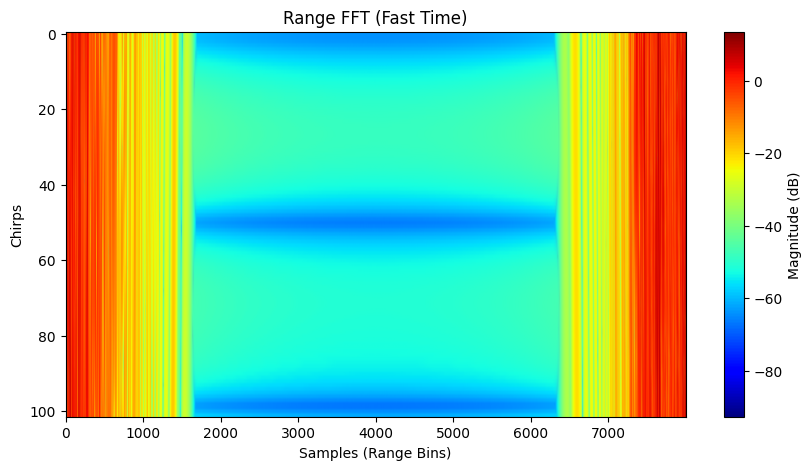

idx_max: 4
3
6


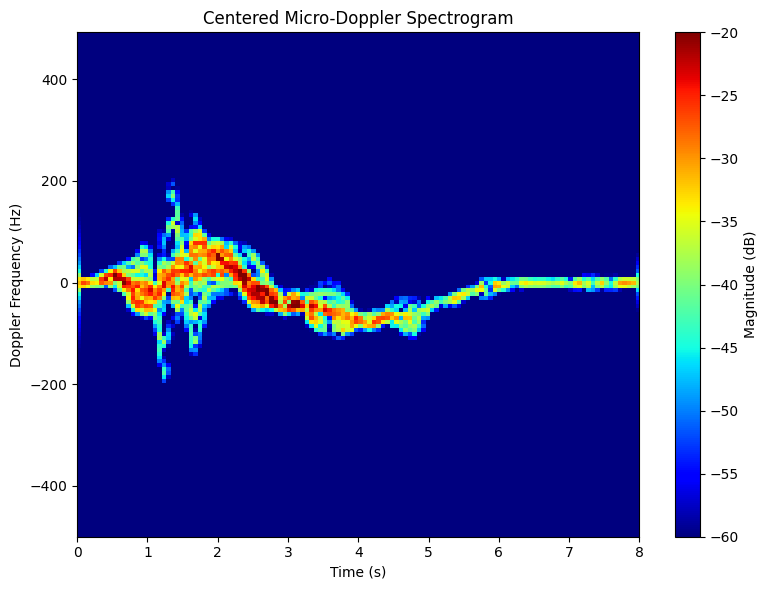

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft




# **Function 1: Compute and visualize the full FFT processing**
def compute_full_fft(signal_data):
    """
    Compute and visualize the full FFT processing (Range FFT + Doppler FFT).

    Parameters:
    - signal_data: numpy array of shape (num_chirps, num_samples)
    """
    num_chirps, num_samples = signal_data.shape

    # Compute Range FFT (Fast-Time FFT)
    range_fft = np.fft.fft(signal_data, axis=1)  # FFT along samples
    range_fft_magnitude = np.abs(range_fft)  # Get magnitude

    # Plot Range FFT
    plt.figure(figsize=(10, 5))
    plt.imshow(20 * np.log10(range_fft_magnitude), aspect='auto', cmap='jet')
    plt.title("Range FFT (Fast Time)")
    plt.xlabel("Samples (Range Bins)")
    plt.ylabel("Chirps")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

    return range_fft_magnitude


# **Function 2: Compute STFT of the given signal**
def compute_stft(signal_data, fs=1e6, window='hann'):
    """
    Compute the Short-Time Fourier Transform (STFT) of the given signal.

    Parameters:
        signal_data (ndarray): Input time-domain signal.
        fs (float): Sampling frequency.
        nperseg (int): Window length for STFT.
        window (str): Window function type.
        noverlap (int or None): Overlap between segments.

    Returns:
        f (ndarray): Frequency bins.
        t (ndarray): Time bins.
        Zxx (ndarray): Complex STFT result.
        Zxx_magnitude (ndarray): Magnitude of STFT in dB.
    """
    # if noverlap is None:
    #     noverlap = nperseg // 2  # Default 50% overlap

    # # Ensure noverlap is strictly less than nperseg
    # if noverlap >= nperseg:
    #     noverlap = nperseg - 1  # This ensures noverlap is strictly less than nperseg

    f, t, Zxx = stft(signal_data, fs=fs, window=window, return_onesided=False)

    # Convert magnitude to dB, ensuring numerical stability
    Zxx_magnitude = 10 * np.log10(np.abs(Zxx) + np.finfo(float).eps)

    return f, t, Zxx, Zxx_magnitude


# **Function 3: Compute entropy for the STFT result**
def compute_entropy(Zxx, tau_index):
    """
    Compute Shannon entropy of the frequency distribution at a specific time index.

    Parameters:
        Zxx (ndarray): STFT complex result.
        tau_index (int): Index corresponding to time τ.

    Returns:
        entropy (float): Shannon entropy in bits.
    """
    magnitude_spectrum = np.abs(Zxx[:, tau_index])

    # Normalize to obtain probability distribution
    P = magnitude_spectrum / np.sum(magnitude_spectrum)
    P = P[P > 0]  # Remove zero elements to avoid log(0)

    # Compute entropy
    entropy = -np.sum(P * np.log2(P))

    return entropy

# **Function 4: Compute average entropy for the STFT result**
def compute_average_entropy(Zxx, t):
    """
    Compute the average entropy across all time bins.

    Parameters:
        Zxx (ndarray): STFT complex result.
        t (ndarray): Time bins.

    Returns:
        average_entropy (float): Average Shannon entropy over time.
    """
    entropies = []
    for tau_index in range(len(t)):
        entropy = compute_entropy(Zxx, tau_index)
        entropies.append(entropy)

    average_entropy = np.mean(entropies)
    return average_entropy

# **Function 5: Process all chirps, including FFT, STFT, and entropy calculations**
def algo1_process_range_bin(data_matrix, r_values):
    """
    Process all chirps in the data matrix: Compute FFT, STFT, entropy, and average entropy.

    Parameters:
        data_matrix (ndarray): Input data matrix of shape (num_chirps, num_samples).
        r_values (list): List of range intervals for defining r_q.
    """
    num_chirps, num_samples = data_matrix.shape
    P_max = []

    # Compute full FFT for all chirps
    range_fft_magnitude = compute_full_fft(data_matrix)

    # Step 2a: Find P_max for each chirp
    for i in range(num_chirps):
        P_max_value = np.max(range_fft_magnitude[i, :])  # Maximum value in the FFT magnitude
        P_max.append(P_max_value)

    # Step 2b: Find most frequent index in P_max
    idx_max = np.argmax(np.bincount(np.array(P_max, dtype=int)))  # Most frequent index

    # Step 3: For each q in Q, define range r_q and compute STFT
    min_entropy = float('inf')  # Initialize min_entropy
    best_r_opt = None  # Initialize best range

    for q in range(len(r_values)):
        r_q = np.arange(idx_max - r_values[q], idx_max + r_values[q])  # Fix: cast idx_max to int

        # Select the range of the signal for the defined r_q
        signal_range = data_matrix[:, r_q]

        # Compute STFT for this range
        for chirp_index in range(num_chirps):
            signal_data = signal_range[chirp_index]
            f, t, Zxx, Zxx_magnitude = compute_stft(signal_data)

            # Step 3b: Calculate average entropy for the range r_q
            avg_entropy = compute_average_entropy(Zxx, t)
            # print(f"Average Entropy for range r_q = {r_values[q]}: {avg_entropy:.4f} bits")

            # Update optimal range-bin if entropy is lower
            if avg_entropy < min_entropy:
                min_entropy = avg_entropy
                best_r_opt = r_q

    # Compute the optimal range-bin interval (Equation 11)
    optimal_range_bin = (idx_max - best_r_opt[0], idx_max + best_r_opt[-1])  # Fix the interval calculation
    return optimal_range_bin

def test_compute_spectrogram_2(data_matrix, r_values, fs_slow=1000.0):
    """
    data_matrix: shape (num_chirps, num_fast_time_samples) if raw,
                 or shape (num_chirps, num_range_bins) if already range-FFT.
    r_values: list of half-widths around idx_max.
    fs_slow: slow-time sampling rate (e.g. 1000 Hz).
    """
    num_chirps, num_samples = data_matrix.shape
    P_max = []
    print("data_matrix shape:", data_matrix.shape)

    # 1) If data_matrix is raw, do range FFT:
    #    But if your data is already range-FFT, skip this.
    # Example:
    # range_fft_data = np.fft.fft(data_matrix, axis=1)
    # range_fft_mag = np.abs(range_fft_data)
    # For demonstration, let's assume data_matrix is ALREADY range-FFT:
    # range_fft_mag = np.abs(data_matrix)
    # Compute full FFT for all chirps
    range_fft_magnitude = compute_full_fft(data_matrix)
    range_fft_data = np.fft.fft(data_matrix.T, axis=1)
    # Step 2a: Find P_max for each chirp
    for i in range(num_chirps):
        P_max_value = np.max(range_fft_magnitude[i, :])  # Maximum value in the FFT magnitude
        P_max.append(P_max_value)

    # Step 2b: Find most frequent index in P_max
    idx_max = np.argmax(np.bincount(np.array(P_max, dtype=int)))  # Most frequent index


    # 2) Find the bin with max average magnitude
    # avg_mag_bins = np.mean(range_fft_mag, axis=0)  # shape: (num_range_bins,)
    # idx_max = np.argmax(avg_mag_bins)
    print("idx_max:", idx_max)

    # 3) Pick a small interval around idx_max
    #    e.g., if r_values = [1], we do ±1 bin around idx_max
    #    Or we just pick r_values[0].
    half_width = r_values[0]
    start = max(0, idx_max - half_width)
    end   = min(num_samples, idx_max + half_width + 1)

    print(start)
    print(end)
    # 4) Accumulate STFT magnitudes across these bins
    accum = None
    count = 0

    nperseg = 128
    noverlap = 64

    for rb in range(start, end):
        slow_time_signal = range_fft_data[:, rb].copy()

        # Ensure nperseg <= length of slow_time_signal
        nperseg_local = min(nperseg, len(slow_time_signal))
        noverlap_local = min(noverlap, nperseg_local - 1)

        # Compute full STFT
        f, t, Zxx = stft(
            slow_time_signal,
            fs=fs_slow,
            nperseg=nperseg_local,
            noverlap=noverlap_local,
            window='hann',
            return_onesided=False
        )

        # Center the Doppler axis
        Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
        f_shifted = np.fft.fftshift(f)

        # Accumulate magnitudes
        mag = np.abs(Zxx_shifted)
        if accum is None:
            accum = mag
        else:
            accum += mag
        count += 1

    # Average across selected bins
    avg_mag = accum / max(count, 1)

    # Convert to dB => see both signal and noise
    spec_db = 20.0 * np.log10(avg_mag + 1e-12)
    return f_shifted, t, spec_db


def plot_spectrogram_centered(f, t, spec_db, title="Centered Micro-Doppler Spectrogram",
                              freq_lims=None, time_lims=None, caxis=None):
    plt.figure(figsize=(8,6))
    extent = [t.min(), t.max(), f[0], f[-1]]
    plt.imshow(spec_db, origin='lower', aspect='auto', extent=extent, cmap='jet')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Doppler Frequency (Hz)")
    cbar = plt.colorbar(label="Magnitude (dB)")

    if caxis is not None:
        plt.clim(caxis[0], caxis[1])
    if freq_lims:
        plt.ylim(freq_lims)
    if time_lims:
        plt.xlim(time_lims)
    plt.tight_layout()
    plt.show()

# def plot_spectrogram_centered(
#     f, t, spec_db,
#     title="Centered Micro-Doppler Spectrogram",
#     freq_lims=None,
#     time_lims=None,
#     caxis=None
# ):
#     plt.figure(figsize=(8,6))
#     extent = [t.min(), t.max(), f[0], f[-1]]
#     plt.imshow(spec_db, origin='lower', aspect='auto', extent=extent, cmap='jet')
#     plt.title(title)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Doppler Frequency (Hz)")
#     cbar = plt.colorbar(label="Magnitude (dB)")
#     if caxis is not None:
#         plt.clim(caxis[0], caxis[1])
#     if freq_lims:
#         plt.ylim(freq_lims)
#     if time_lims:
#         plt.xlim(time_lims)
#     plt.tight_layout()
#     plt.show()

file_path = os.getcwd() + '/W/W/3m_0_file60.mat'
data_matrix = load_radar_data(file_path)
# r_values = [5, 10, 20, 30]  # Define some range intervals
fs_slow = 1000.0
# optimal_range_bin = (7,10)
# f_centered, t, spec_db_centered = compute_micro_doppler_spectrogram_centered_no_clutter(
r_values=[1]

f_centered, t, spec_db_centered =  test_compute_spectrogram_2(data_matrix,r_values,fs_slow=1000.0)

plot_spectrogram_centered(
    f_centered, t, spec_db_centered,
    title="Centered Micro-Doppler Spectrogram",
    # freq_lims=(-200, 200),  # zoom to expected Doppler range for human motion
    # time_lims=(0, 8),       # if the execution time is 8 s
    caxis=(-60, -20)        # adjust dynamic range so the noise (e.g., around -60 dB) and signal (~-20 dB) are visible
)


In [193]:

def add_awgn(data, snr_db):
    """
    Add white Gaussian noise to 'data' to achieve the desired SNR in dB.
    data: numpy array (can be real or complex).
    snr_db: desired SNR in dB (float).
    Returns: noisy_data (same shape as data).
    """
    # 1) Compute signal power
    sig_power = np.mean(np.abs(data)**2)
    # 2) Compute noise variance for desired SNR
    snr_linear = 10**(snr_db/10.0)
    noise_var = sig_power / snr_linear

    # 3) Generate noise
    if np.iscomplexobj(data):
        # Complex data => complex noise
        noise = (np.sqrt(noise_var/2.0) *
                 (np.random.randn(*data.shape) + 1j*np.random.randn(*data.shape)))
    else:
        # Real data => real noise
        noise = np.sqrt(noise_var)*np.random.randn(*data.shape)

    # 4) Add noise
    noisy_data = data + noise
    return noisy_data

# Example function to do everything: generate & plot multiple noisy spectrograms
def generate_noisy_spectrograms(data_matrix, snr_values, fs_slow=1000.0):
    """
    data_matrix: your original data (num_chirps x num_samples)
    snr_values: list of SNRs in dB, e.g. [-15, -5, 0, 5, 10]
    fs_slow: slow-time sampling frequency
    """
    for snr_db in snr_values:
        # Create a noisy copy
        data_noisy = add_awgn(data_matrix, snr_db)

        # Then pass 'data_noisy' to your spectrogram function (like test_compute_spectrogram_2)
        f_centered, t, spec_db_centered = test_compute_spectrogram_2(data_noisy, r_values=[1], fs_slow=fs_slow)

        # Plot
        plt.figure(figsize=(8,6))
        extent = [t.min(), t.max(), f_centered[0], f_centered[-1]]
        plt.imshow(spec_db_centered, origin='lower', aspect='auto', extent=extent, cmap='jet')
        plt.title(f"Centered Micro-Doppler Spectrogram (SNR={snr_db} dB)")
        plt.xlabel("Time (s)")
        plt.ylabel("Doppler Frequency (Hz)")
        cbar = plt.colorbar(label="Magnitude (dB)")
        plt.clim(-60, -20)  # or adjust
        plt.ylim([-400, 400]) # if you want to zoom
        plt.xlim([0, 8])      # if you have 8 s
        plt.tight_layout()
        plt.show()

# USAGE EXAMPLE
# 1) Load your data
# data_matrix = load_radar_data(...)
# 2) Add noise & plot multiple spectrograms
snr_list = [-15, -5, 0, 5, 10]
generate_noisy_spectrograms(data_matrix, snr_list, fs_slow=1000.0)

Output hidden; open in https://colab.research.google.com to view.

In [194]:
snr_levels = [-15, -5, 0, 5, 10]  # SNR values in dB
noisy_data_dict = {}

for snr in snr_levels:
    noisy_data = add_awgn(data_matrix, snr)
    noisy_data_dict[snr] = noisy_data
    # Optionally, save to file:
    filename = f"data_noise_{snr}dB.npy"
    np.save(filename, noisy_data)
    print(f"Saved noisy data at {snr} dB to {filename}")

# Now you have variables like:
data_noise_minus15_dB = noisy_data_dict[-15]
data_noise_minus5_dB  = noisy_data_dict[-5]
data_noise_0_dB       = noisy_data_dict[0]
data_noise_5_dB       = noisy_data_dict[5]
data_noise_10_dB      = noisy_data_dict[10]

Saved noisy data at -15 dB to data_noise_-15dB.npy
Saved noisy data at -5 dB to data_noise_-5dB.npy
Saved noisy data at 0 dB to data_noise_0dB.npy
Saved noisy data at 5 dB to data_noise_5dB.npy
Saved noisy data at 10 dB to data_noise_10dB.npy


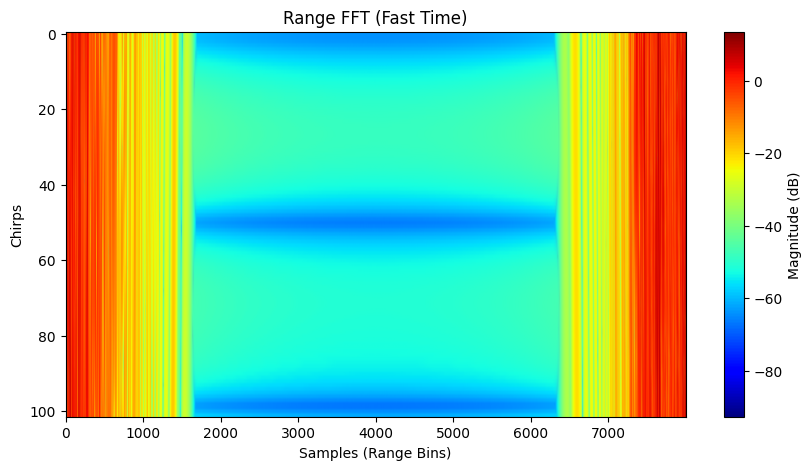

Optimal range-bin for /content/drive/MyDrive/Huy/ECE613_new/W/W/3m_0_file60.mat: (np.int64(1), np.int64(8))
range_bins: (np.int64(1), np.int64(8))


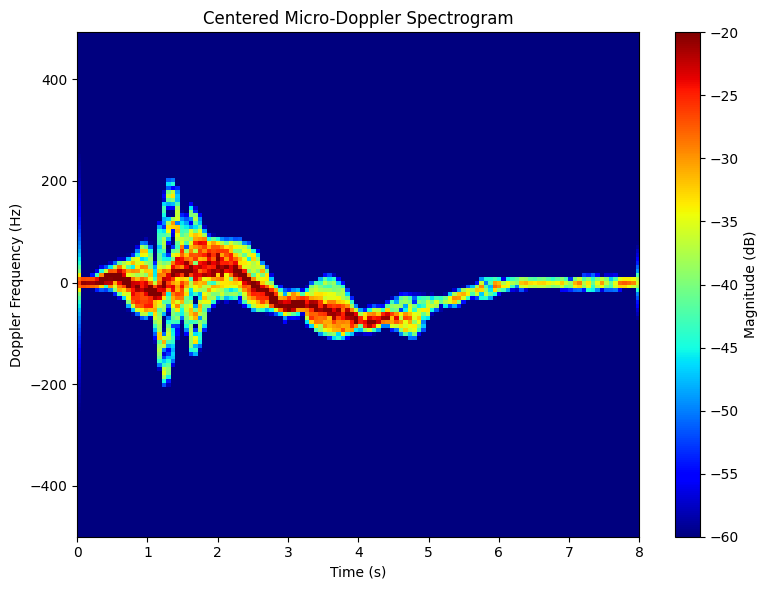

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

def test_func(
    data_matrix,
    range_bins,
    fs_slow,
    nperseg=128,      # reduced for finer resolution
    noverlap=64,      # ~50% overlap
    window=('gaussian',14),# using a Gaussian window as in the denoising stage
    remove_clutter=False
):
    """
    data_matrix: (num_chirps, num_range_bins)
    range_bins: tuple (start, end) for selected range bins (ideally 3 bins: idxmax-1 to idxmax+1)
    fs_slow: slow-time (chirp) sampling rate in Hz (e.g. 1000 Hz if 1 ms per chirp)

    This function computes the STFT for each selected range bin (without subtracting the STFT column mean),
    applies an FFT shift to center 0 Hz, and then averages the magnitudes.

    Returns:
      f_shifted: frequency bins (centered)
      t: time bins
      spec_db: spectrogram in dB (which will preserve noise granularity)
    """
    print(f"range_bins: {range_bins}")
    start, end = range_bins
    accum = None
    count = 0


    for rb in range(start, end):
        slow_time_signal = data_matrix[:, rb].copy()

        # Optional slow-time DC removal (NOT the STFT column means)
        if remove_clutter:
            slow_time_signal -= np.mean(slow_time_signal)

        # Ensure nperseg <= length of slow_time_signal
        nperseg_local = min(nperseg, len(slow_time_signal))
        noverlap_local = min(noverlap, nperseg_local - 1)

        # Compute full STFT
        f, t, Zxx = stft(
            slow_time_signal,
            fs=fs_slow,
            nperseg=nperseg_local,
            noverlap=noverlap_local,
            window=window,
            return_onesided=False
        )

        # Center the Doppler axis
        Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
        f_shifted = np.fft.fftshift(f)

        # Accumulate magnitudes
        mag = np.abs(Zxx_shifted)
        if accum is None:
            accum = mag
        else:
            accum += mag
        count += 1

    # Average across selected bins
    avg_mag = accum / max(count, 1)

    # Convert to dB => see both signal and noise
    spec_db = 20.0 * np.log10(avg_mag + 1e-12)
    return f_shifted, t, spec_db



data_matrix = load_radar_data(file_path)
range_fft_data = np.fft.fft(data_matrix.T, axis=1)

# r_values = [5, 10, 20, 30]  # Define some range intervals
# r_values = [1,2,3]  # Define some range intervals
r_values = [1]
optimal_range_bin = algo1_process_range_bin(data_matrix, r_values)
print(f"Optimal range-bin for {file_path}: {optimal_range_bin}")
fs_slow = 1000.0
# optimal_range_bin = (7,10)
# f_centered, t, spec_db_centered = compute_micro_doppler_spectrogram_centered_no_clutter(
f_centered, t, spec_db_centered =  test_func(
    range_fft_data, optimal_range_bin, fs_slow,
    # nperseg=128, noverlap=64, window=('gaussian',14),remove_clutter=False
    nperseg=128, noverlap=64, window='hann',remove_clutter=False
)


# 5. Plot with an appropriate color scale that shows both the target and the noise
plot_spectrogram_centered(
    f_centered, t, spec_db_centered,
    title="Centered Micro-Doppler Spectrogram",
    # freq_lims=(-200, 200),  # zoom to expected Doppler range for human motion
    # time_lims=(0, 8),       # if the execution time is 8 s
    caxis=(-60, -20)        # adjust dynamic range so the noise (e.g., around -60 dB) and signal (~-20 dB) are visible
)


### Cut-Threshold

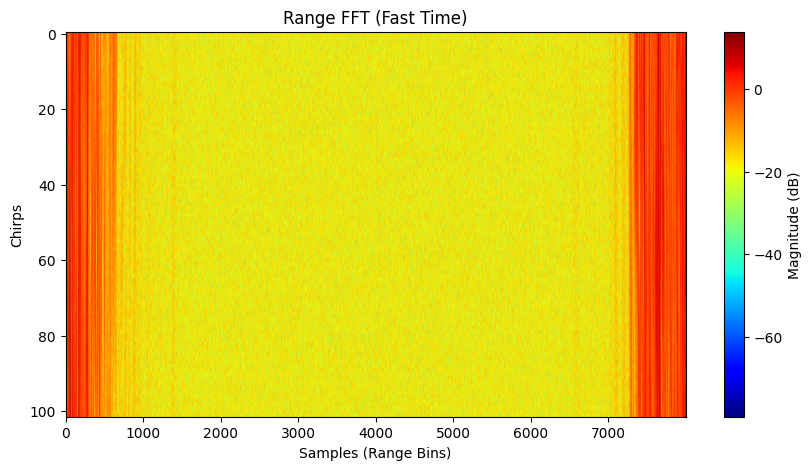

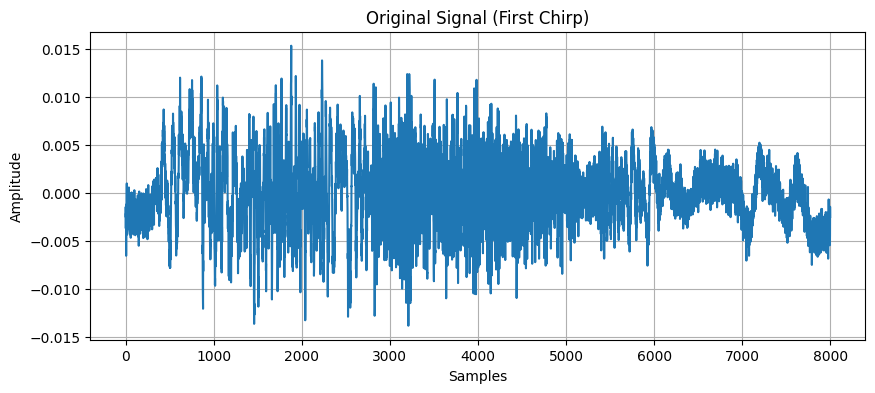

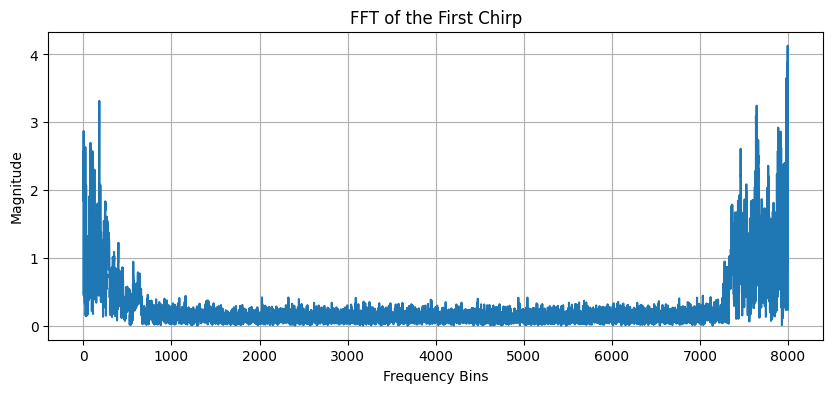

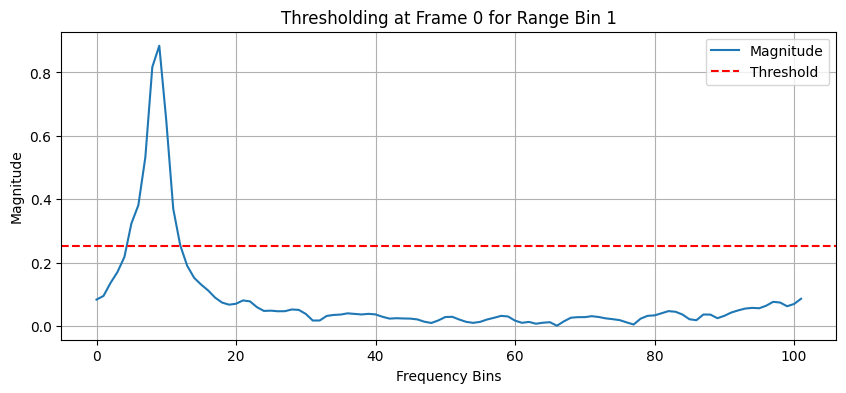

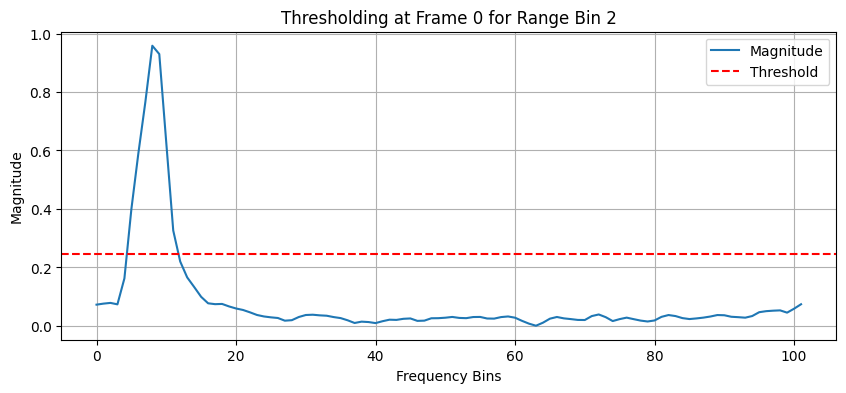

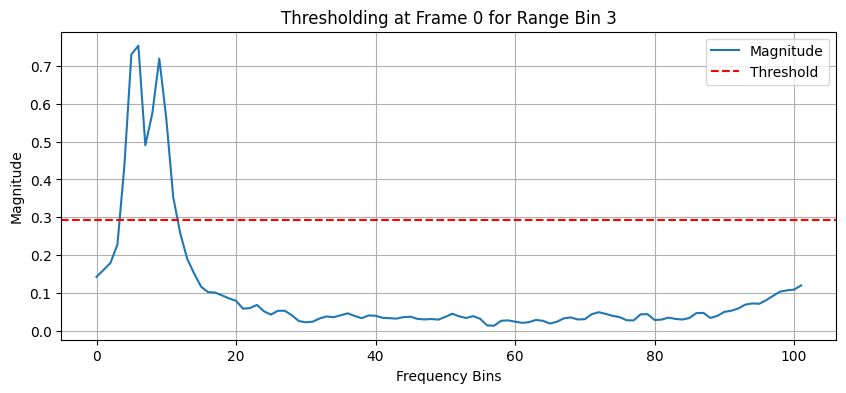

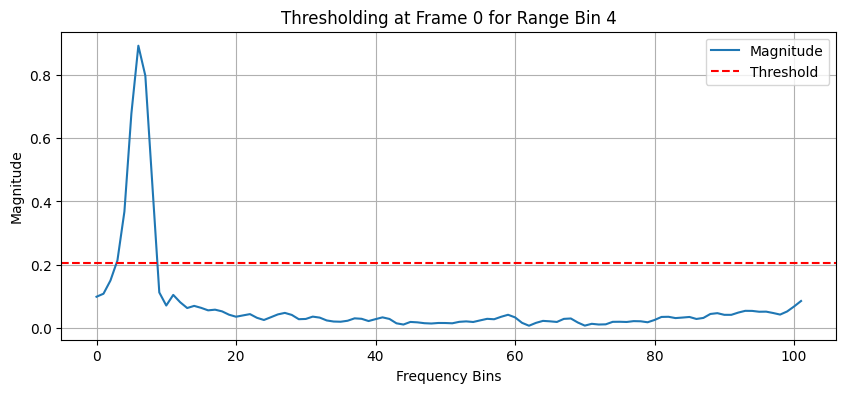

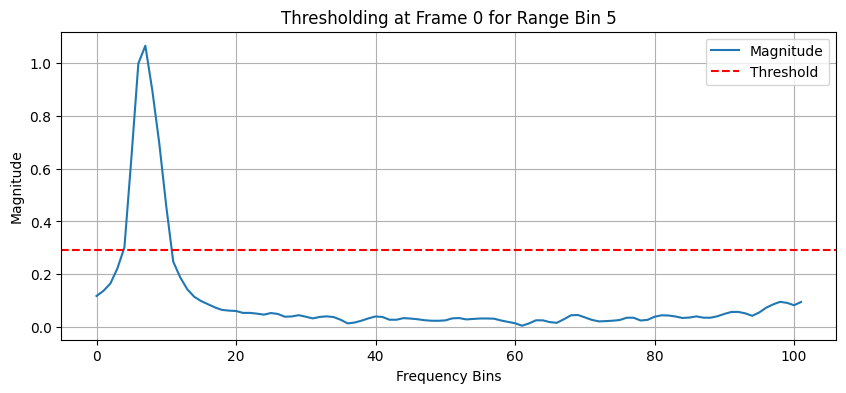

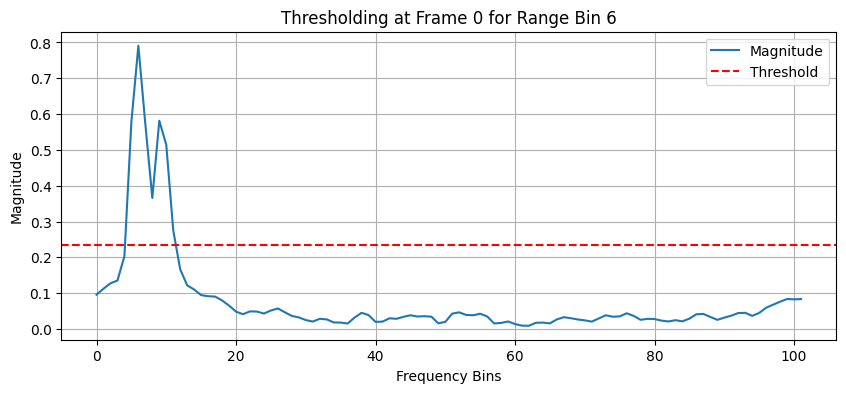

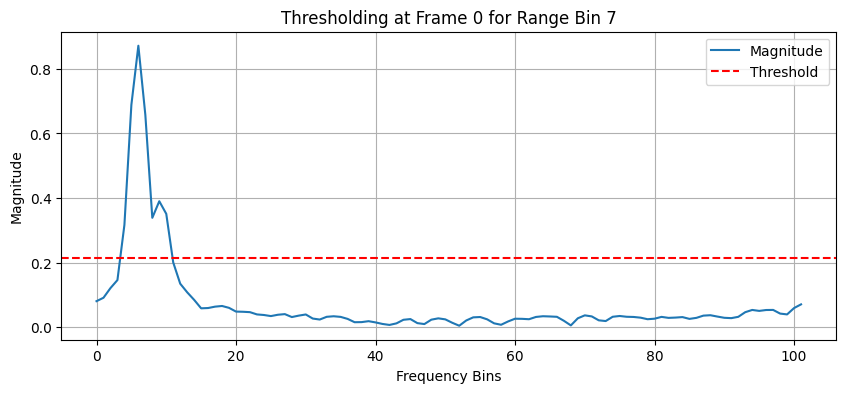

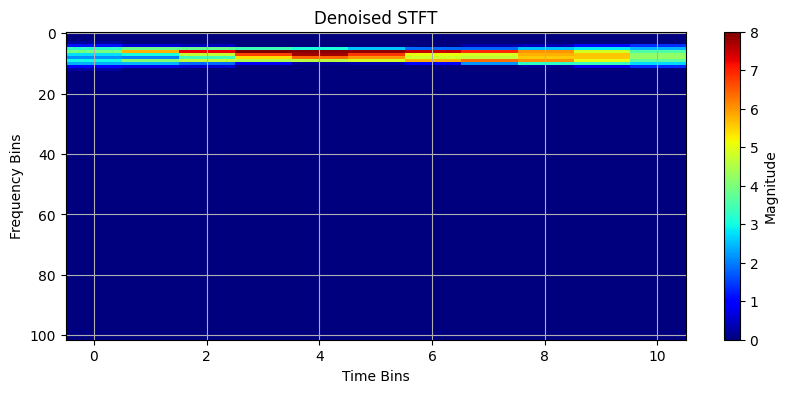

In [209]:
def algo2_denoise(signal_data, optimal_range, Th=3):
      """Algorithm 2: Denoise using adaptive STFT thresholding."""
      num_chirps, num_samples = signal_data.shape
      range_fft = np.fft.fft(signal_data, axis=1)
      start, end = optimal_range
      selected_bins = range(start, end)

      # window = ('gaussian', 14)
      window = 'hann'
      denoised_stft = None

      # Visualize the original signal (first chirp)
      plt.figure(figsize=(10, 4))
      plt.plot(signal_data[0, :])
      plt.title("Original Signal (First Chirp)")
      plt.xlabel("Samples")
      plt.ylabel("Amplitude")
      plt.grid()
      plt.show()

      # Visualize the FFT of the first chirp
      plt.figure(figsize=(10, 4))
      plt.plot(np.abs(range_fft[0, :]))
      plt.title("FFT of the First Chirp")
      plt.xlabel("Frequency Bins")
      plt.ylabel("Magnitude")
      plt.grid()
      plt.show()

      for rb in selected_bins:
          slow_time_signal = range_fft[:, rb]
          # Dynamic nperseg and noverlap
          nperseg = min(128, len(slow_time_signal))
          noverlap = int(0.9 * nperseg)
          _, t, Zxx = signal.stft(slow_time_signal, nperseg=nperseg, noverlap=noverlap, window=window)

          for i in range(Zxx.shape[1]):
              frame = Zxx[:, i].copy()
              mag = np.abs(frame)
              avg_mag = np.mean(mag)
              threshold = Th * avg_mag
              mask = mag > threshold
              frame[~mask] = 0

              if denoised_stft is None:
                  denoised_stft = np.zeros_like(Zxx)
              denoised_stft[:, i] += frame

              # Visualize the thresholding process
              if i == 0:  # Only show for the first time slice for simplicity
                  plt.figure(figsize=(10, 4))
                  plt.plot(mag, label="Magnitude")
                  plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
                  plt.title(f"Thresholding at Frame {i} for Range Bin {rb}")
                  plt.xlabel("Frequency Bins")
                  plt.ylabel("Magnitude")
                  plt.legend()
                  plt.grid()
                  plt.show()

      # Visualize the denoised STFT
      plt.figure(figsize=(10, 4))
      plt.imshow(np.abs(denoised_stft), aspect='auto', cmap='jet')
      plt.title("Denoised STFT")
      plt.xlabel("Time Bins")
      plt.ylabel("Frequency Bins")
      plt.colorbar(label="Magnitude")
      plt.grid()
      plt.show()

      return denoised_stft

# Example usage
# optimal_range = algo1_process_range_bin(data_matrix, r_values)
data_noise_10_dB      = noisy_data_dict[10]
optimal_range = algo1_process_range_bin(data_noise_10_dB, r_values)
Th = 3  # Threshold value determined empirically.
denoised_stft = algo2_denoise(data_noise_10_dB, optimal_range, Th)


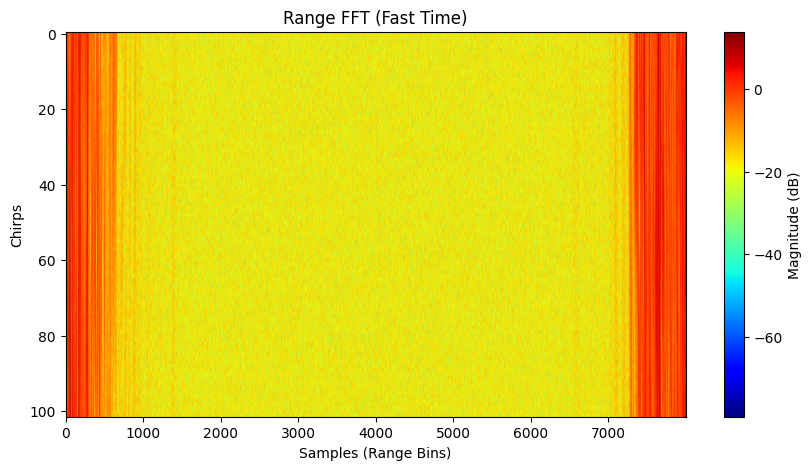

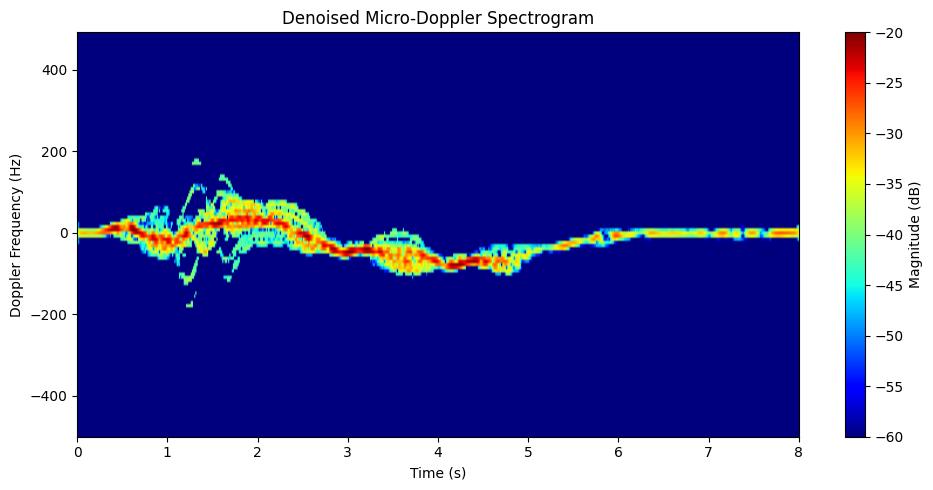

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def test_algo2_denoise(signal_data, optimal_range, Th=3, fs_slow=1000.0):
    """
    Algorithm 2: Denoise using adaptive STFT thresholding.
    Instead of plotting directly, returns the thresholded STFT in complex form,
    plus frequency/time arrays so you can plot a spectrogram that matches your
    'raw/noisy' style.

    Parameters:
      signal_data: shape (num_chirps, num_samples)
      optimal_range: (start, end) for the selected range bins
      Th: threshold factor
      fs_slow: slow-time sampling rate (e.g. 1000 Hz if 1 ms per chirp)

    Returns:
      denoised_stft_accum: complex 2D array (freq_bins x time_frames),
                           after thresholding & averaging across the selected bins
      f: frequency bins (in Hz)
      t: time bins (in s)
    """
    num_chirps, num_samples = signal_data.shape

    # 1) Range FFT (fast-time)
    range_fft = np.fft.fft(signal_data.T, axis=1)  # shape: (num_chirps, num_samples)

    start, end = optimal_range
    selected_bins = range(start, end)

    denoised_stft_accum = None
    count_bins = 0

    # For each selected range bin, do STFT of slow-time signal & threshold
    for rb in selected_bins:
        slow_time_signal = range_fft[:, rb]

        nperseg = min(128, len(slow_time_signal))
        noverlap = int(0.9 * nperseg)
        f, t, Zxx = signal.stft(
            slow_time_signal,
            fs=fs_slow,
            nperseg=nperseg,
            noverlap=noverlap,
            # window=('gaussian', 14),
            window='hann',
            return_onesided=False
        )

        # Adaptive thresholding for each time frame
        Zxx_denoised = np.zeros_like(Zxx, dtype=complex)
        for i in range(Zxx.shape[1]):
            frame = Zxx[:, i].copy()
            mag = np.abs(frame)
            avg_mag = np.mean(mag)
            threshold = Th * avg_mag
            mask = (mag > threshold)
            frame[~mask] = 0
            Zxx_denoised[:, i] = frame

        if denoised_stft_accum is None:
            denoised_stft_accum = np.zeros_like(Zxx_denoised, dtype=complex)
        denoised_stft_accum += Zxx_denoised
        count_bins += 1

    if count_bins > 0:
        denoised_stft_accum /= count_bins
    else:
        print("Warning: No bins were selected. Returning None.")
        return None, None, None

    return denoised_stft_accum, f, t

def plot_denoised_spectrogram(denoised_stft_accum, f, t, title="Denoised Micro-Doppler Spectrogram",caxis=None):
    """
    Plot the denoised STFT in the same style as your raw/noisy spectrogram.
    """
    denoised_mag = np.abs(denoised_stft_accum)
    # range_fft_data = np.fft.fft(denoised_stft_accum.T, axis=1)

    # f, t, Zxx = stft(
    #     slow_time_signal,
    #     fs=fs_slow,
    #     nperseg=nperseg_local,
    #     noverlap=noverlap_local,
    #     window='hann',
    #     return_onesided=False
    # )

    # denoised_db = 20.0 * np.log10(np.abs(range_fft_data) + 1e-12)
    denoised_db = 20.0 * np.log10(denoised_mag + 1e-12)

    # fftshift along freq axis
    denoised_db_shifted = np.fft.fftshift(denoised_db, axes=0)
    f_shifted = np.fft.fftshift(f)

    # Plot
    plt.figure(figsize=(10,5))
    extent = [t[0], t[-1], f_shifted[0], f_shifted[-1]]
    plt.imshow(denoised_db_shifted, origin='lower', aspect='auto',
               extent=extent, cmap='jet')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Doppler Frequency (Hz)")
    plt.colorbar(label="Magnitude (dB)")
    if caxis is not None:
        plt.clim(caxis[0], caxis[1])

    plt.tight_layout()
    plt.show()

data_noise_10_dB      = noisy_data_dict[10]
optimal_range = algo1_process_range_bin(data_noise_10_dB, r_values)
Th = 3  # Threshold value determined empirically.
denoised_stft, f_den, t_den = test_algo2_denoise(data_noise_10_dB, optimal_range, Th=3, fs_slow=1000.0)

plot_denoised_spectrogram(denoised_stft, f_den, t_den, title="Denoised Micro-Doppler Spectrogram",caxis=(-60, -20))
# plot_spectrogram_centered(
#     f_den, t_den, denoised_stft,
#     title="Denoised Micro-Doppler Spectrogram",
#     # freq_lims=(-200, 200),  # zoom to expected Doppler range for human motion
#     # time_lims=(0, 8),       # if the execution time is 8 s
#     caxis=(-60, -20)        # adjust dynamic range so the noise (e.g., around -60 dB) and signal (~-20 dB) are visible
# )


### Process all files

/content/drive/MyDrive/Huy/ECE613_new/W/single
Processing file: 3m_0_file5.mat


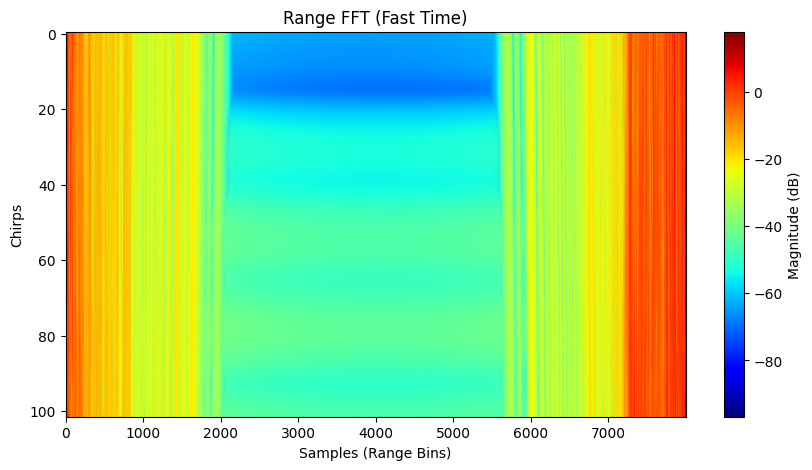

Optimal range-bin for 3m_0_file5.mat: (np.int64(5), np.int64(14))


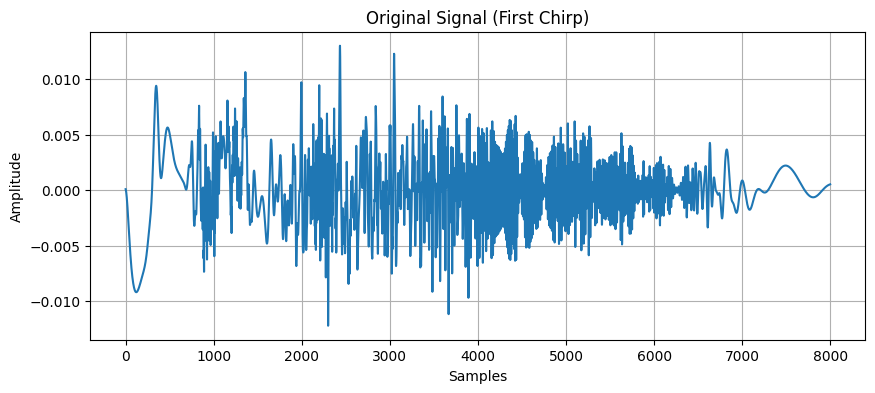

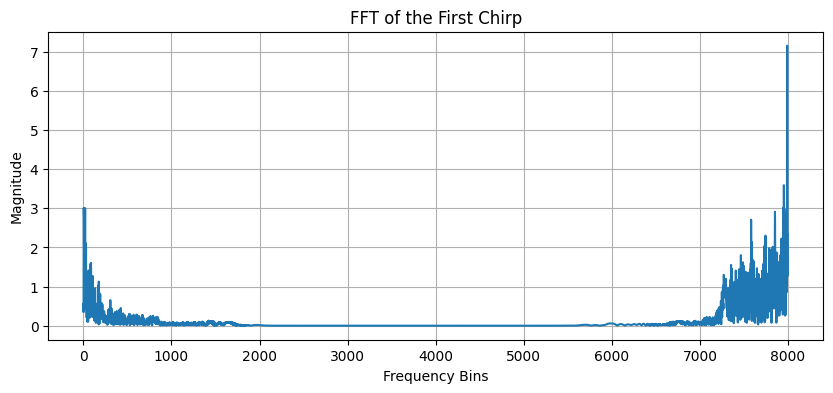

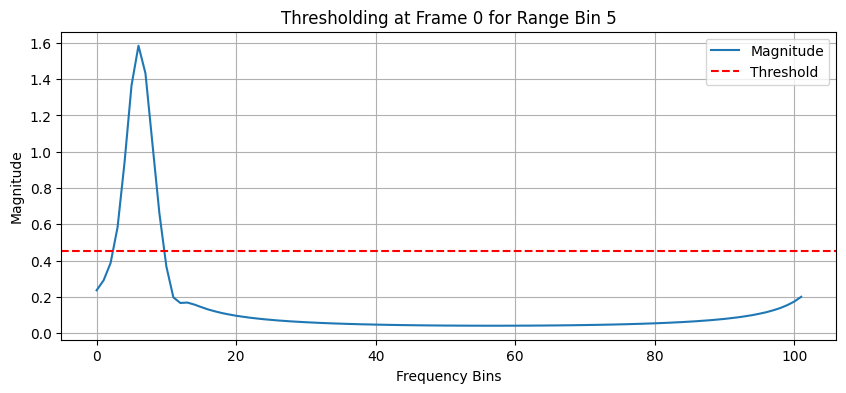

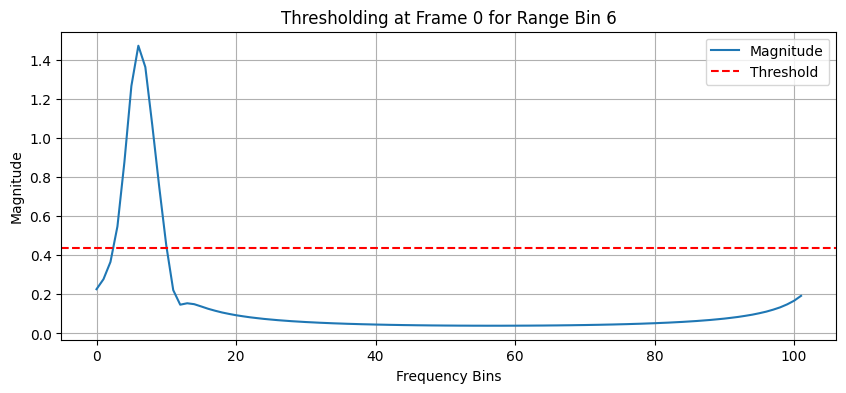

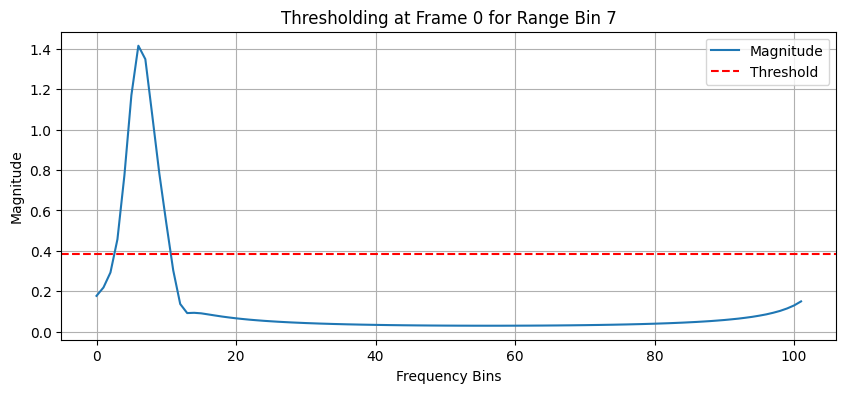

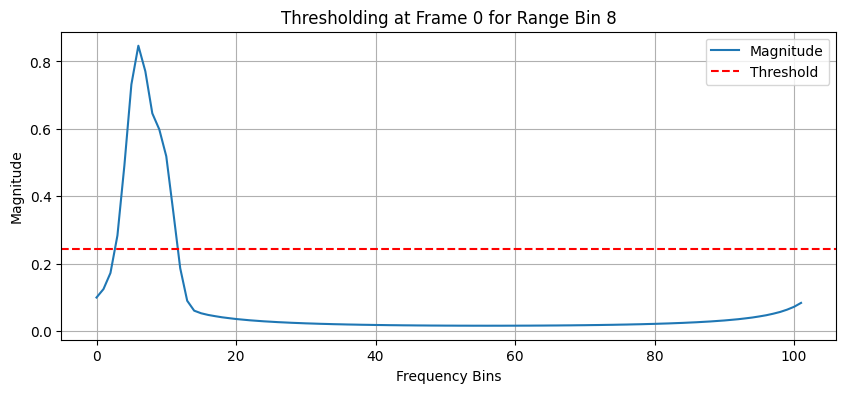

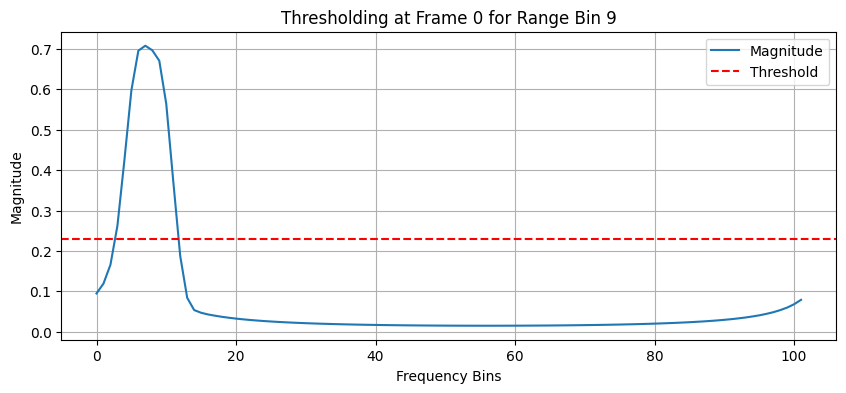

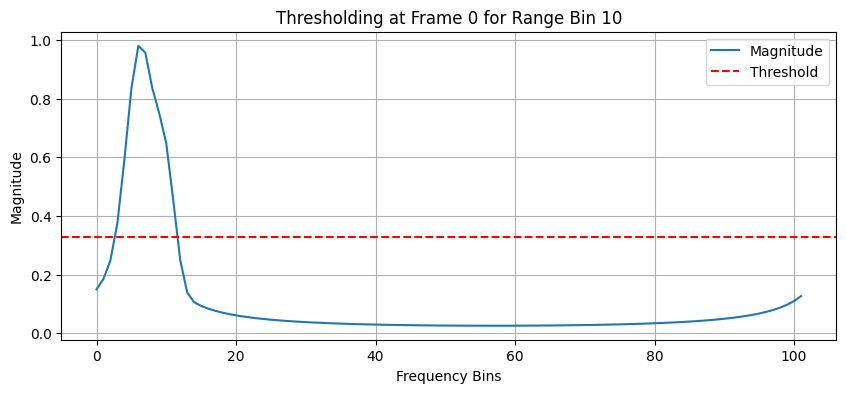

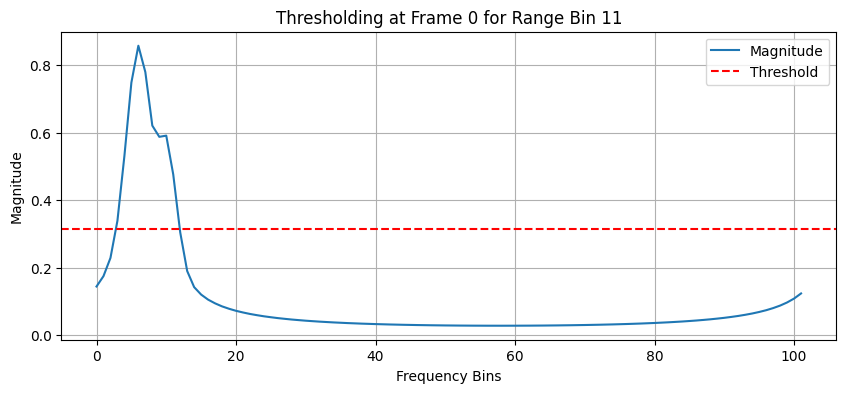

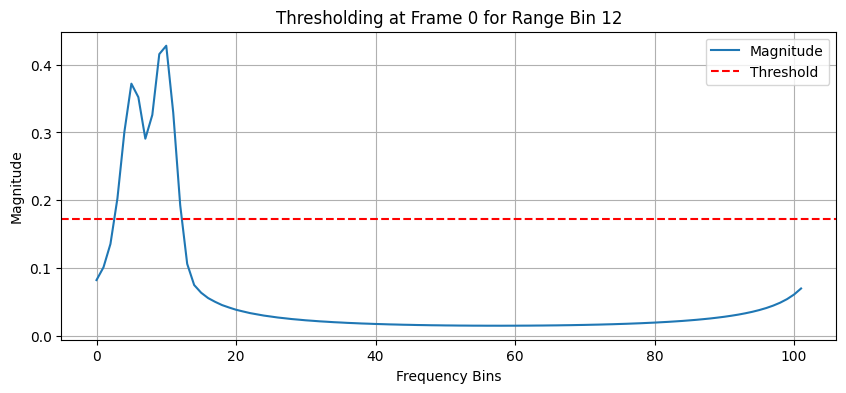

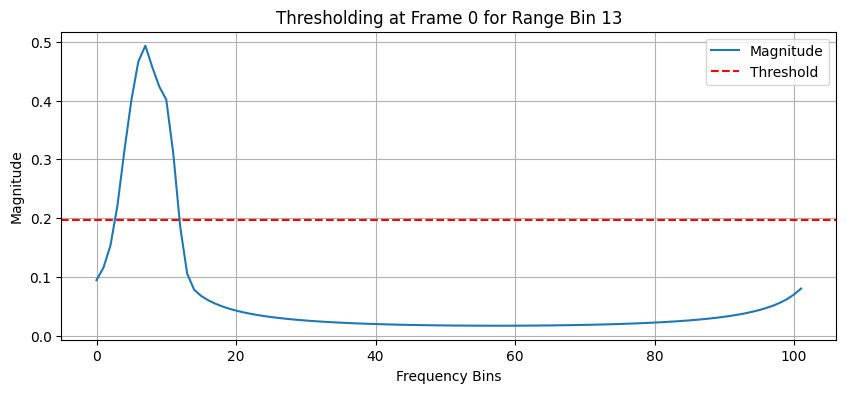

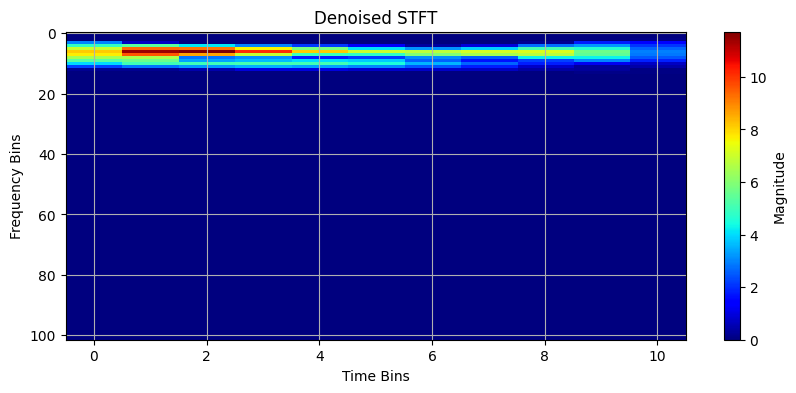

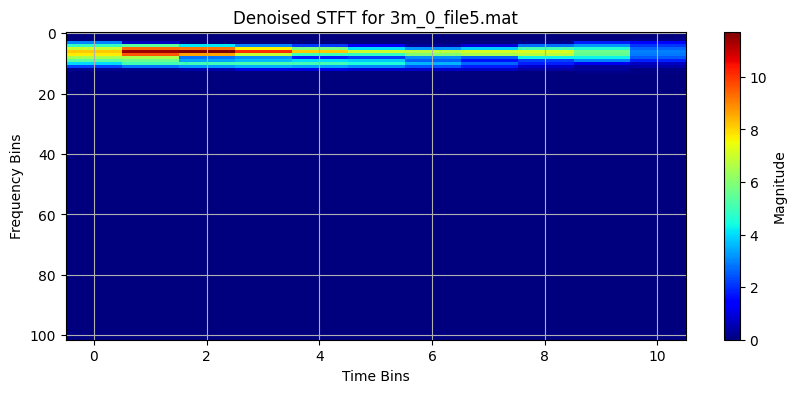

In [155]:
# Define the function to load radar data from a .mat file
def load_radar_data(file_path):
    """Load radar data from .mat file."""
    data = scipy.io.loadmat(file_path)
    signal_data = data['received_time_domain_signal']
    return signal_data


# Process all files in the directory
def process_all_files_in_directory(directory_path, r_values, threshold=3):
    """
    Process all .mat files in the directory.

    Parameters:
    - directory_path: Path to the folder containing .mat files.
    - r_values: Range intervals for processing.
    - threshold: Threshold for denoising.
    """
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.mat'):
            file_path = os.path.join(directory_path, file_name)
            print(f"Processing file: {file_name}")

            # Load data from the .mat file
            data_matrix = load_radar_data(file_path)

            # Process the file (e.g., compute FFT, STFT, entropy, denoise)
            optimal_range_bin = algo1_process_range_bin(data_matrix, r_values)
            print(f"Optimal range-bin for {file_name}: {optimal_range_bin}")

            # Apply denoising
            denoised_stft = algo2_denoise(data_matrix, optimal_range_bin, Th=threshold)

            # Optionally: Save or visualize the denoised result for each file
            plt.figure(figsize=(10, 4))
            plt.imshow(np.abs(denoised_stft), aspect='auto', cmap='jet')
            plt.title(f"Denoised STFT for {file_name}")
            plt.xlabel("Time Bins")
            plt.ylabel("Frequency Bins")
            plt.colorbar(label="Magnitude")
            plt.grid()
            plt.show()

# Example usage:
directory_path = os.getcwd()+'/W/single'  # Path to the folder with .mat files
print(directory_path)
r_values = [5, 10, 20, 30]  # Define some range intervals
process_all_files_in_directory(directory_path, r_values)

 ### REPLICATE AGAIN


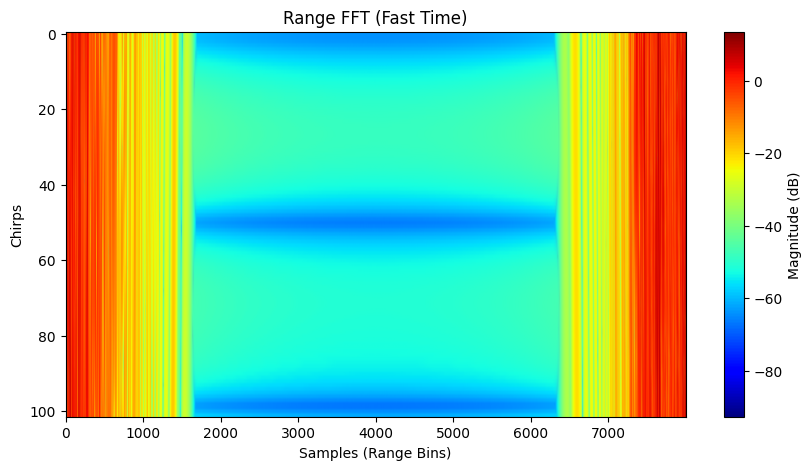

Optimal range-bin: (np.int64(0), np.int64(9))


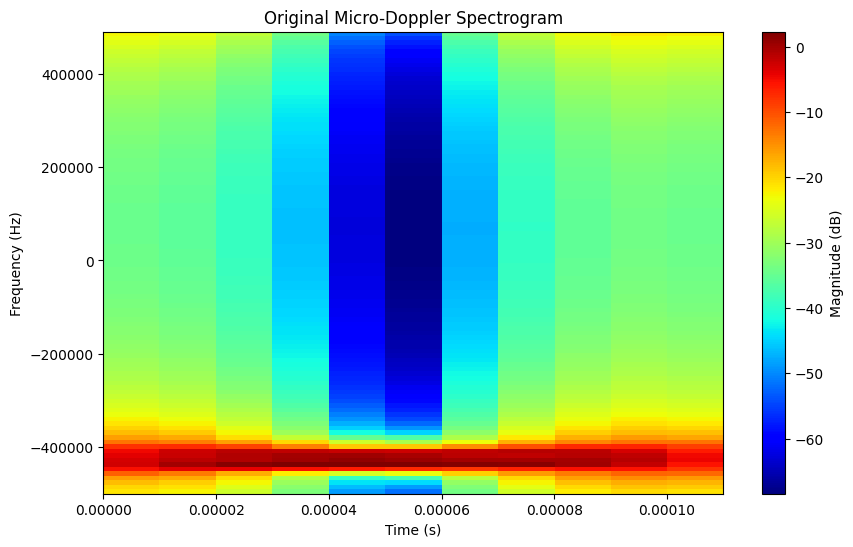

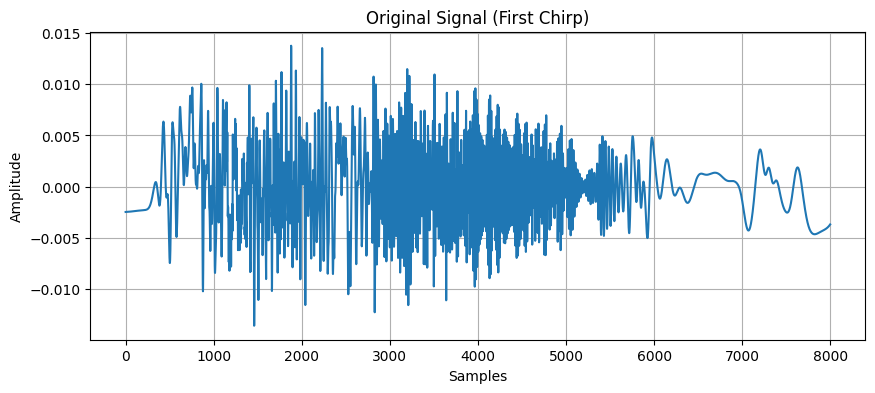

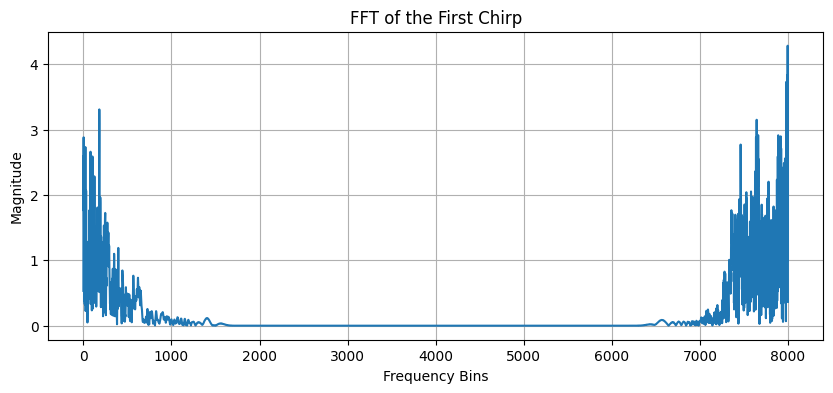

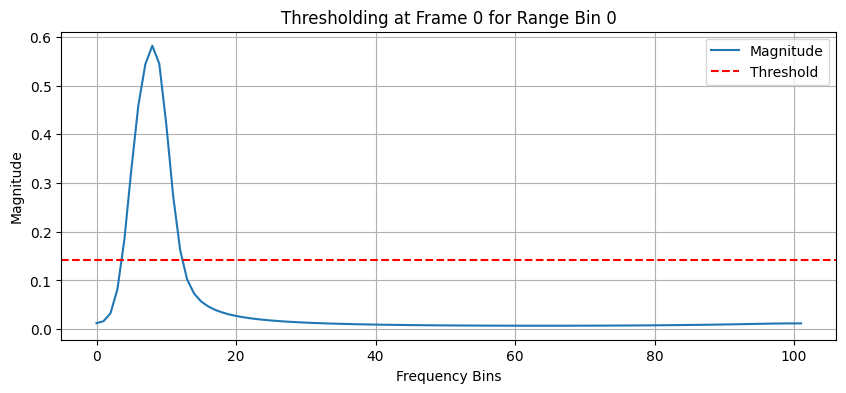

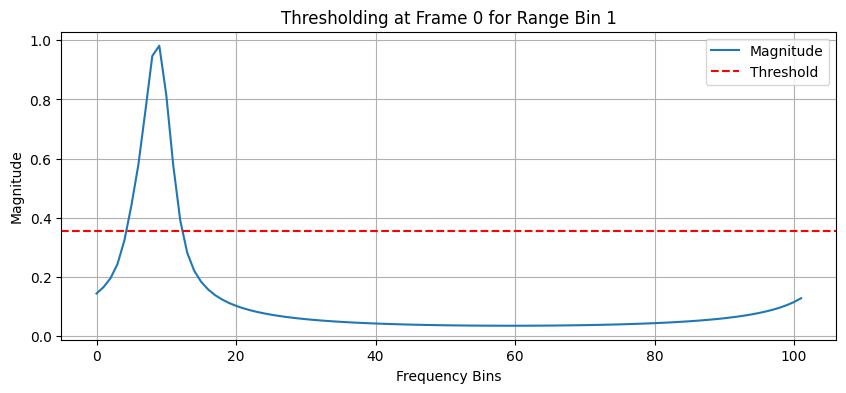

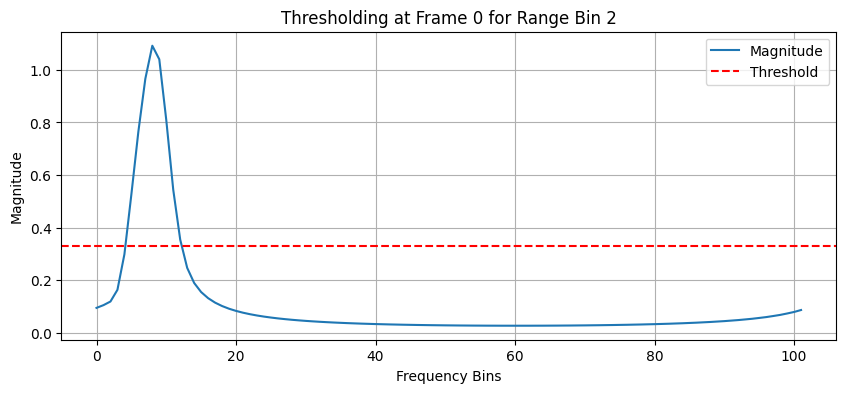

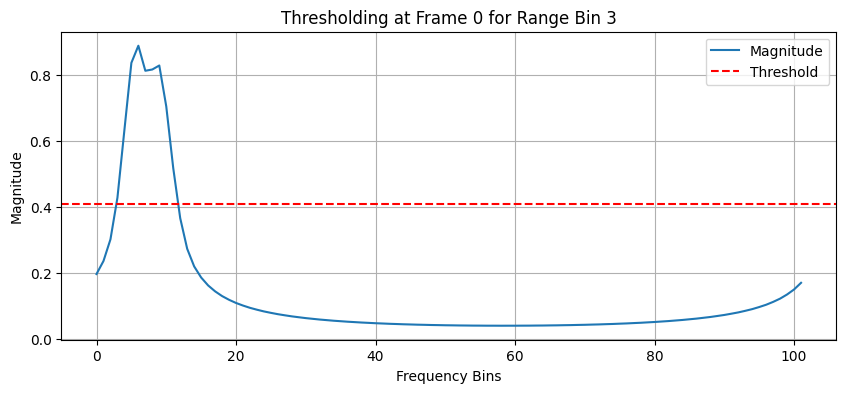

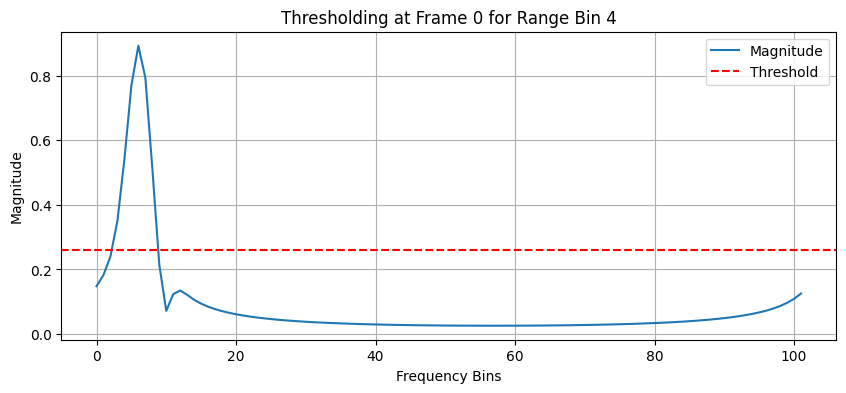

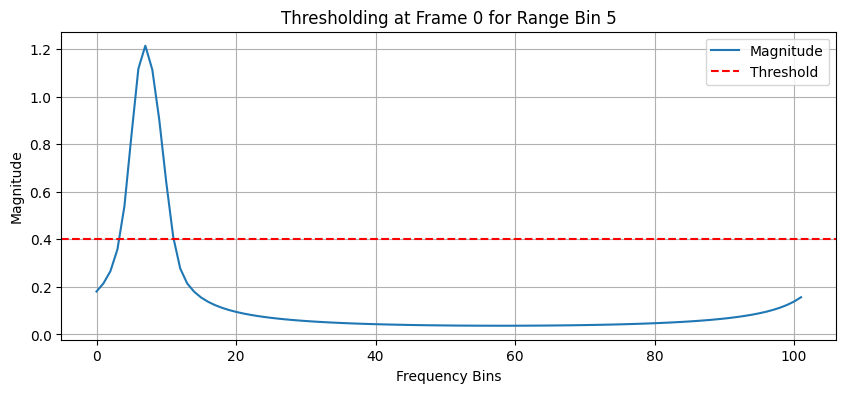

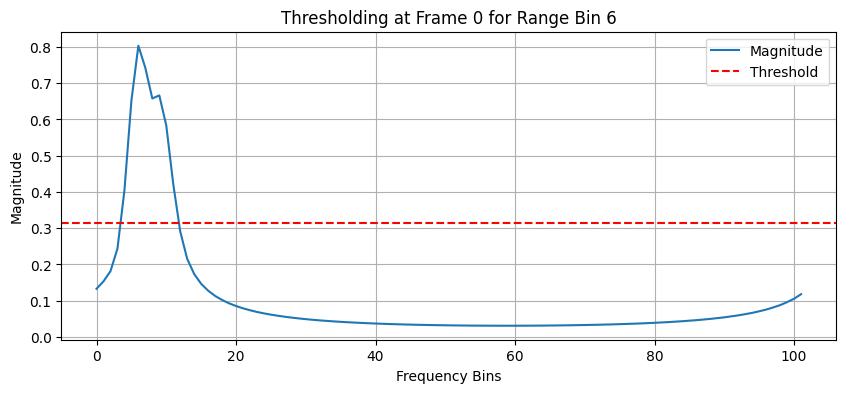

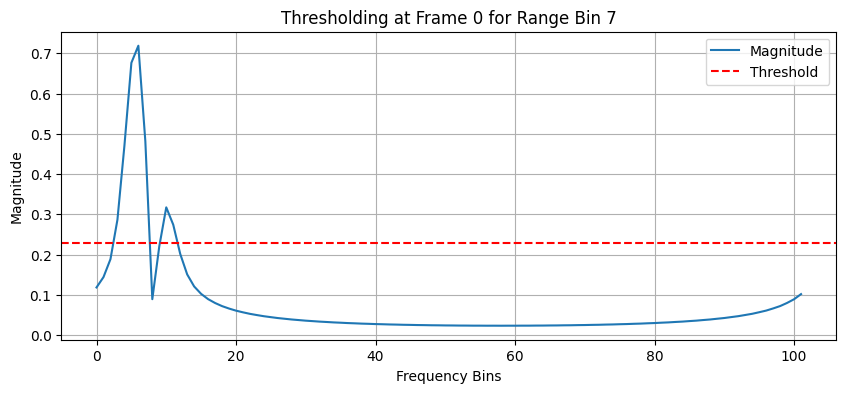

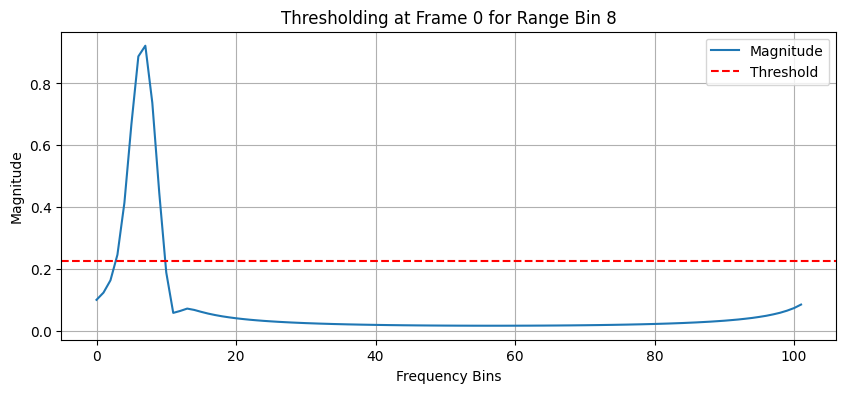

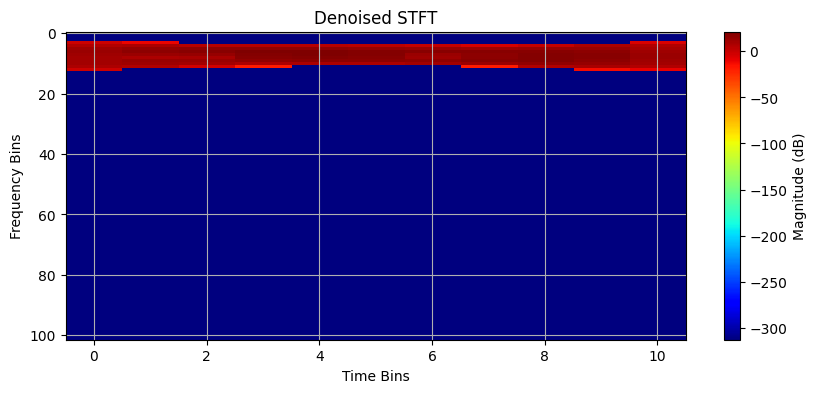

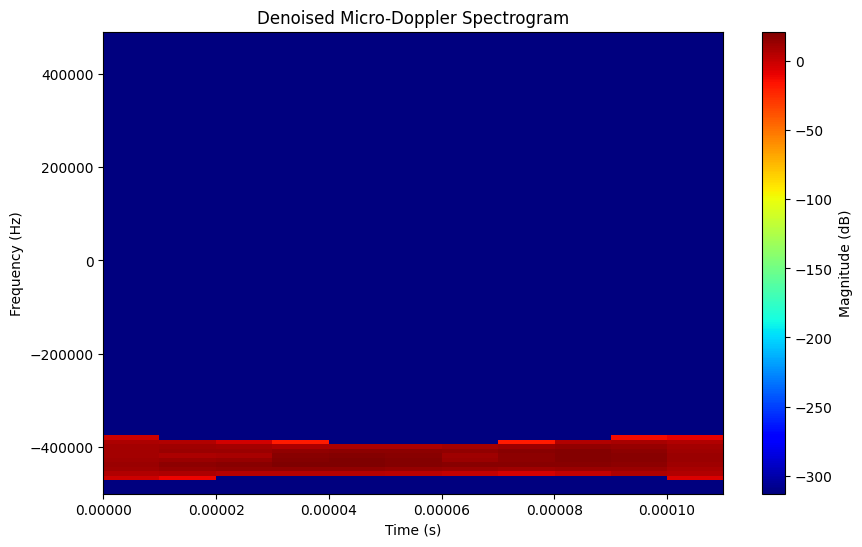

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy import signal

# ---------------------------
# Algorithm 1 Functions
# ---------------------------

def compute_full_fft(signal_data):
    """
    Compute and visualize the full FFT processing (Range FFT + Doppler FFT).
    Parameters:
      signal_data: numpy array of shape (num_chirps, num_samples)
    Returns:
      range_fft_magnitude: FFT magnitude (for each chirp)
    """
    num_chirps, num_samples = signal_data.shape

    # Compute Range FFT (fast-time FFT)
    range_fft = np.fft.fft(signal_data, axis=1)
    range_fft_magnitude = np.abs(range_fft)

    # Plot Range FFT (in dB)
    plt.figure(figsize=(10, 5))
    plt.imshow(20 * np.log10(range_fft_magnitude + np.finfo(float).eps),
               aspect='auto', cmap='jet')
    plt.title("Range FFT (Fast Time)")
    plt.xlabel("Samples (Range Bins)")
    plt.ylabel("Chirps")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

    return range_fft_magnitude

def compute_stft(signal_data, fs=1e6, window='hann'):
    """
    Compute the STFT of the given 1D signal.
    Parameters:
      signal_data: 1D numpy array (time-domain signal)
      fs: Sampling frequency (default: 1e6)
      window: Window type (default: 'hann')
    Returns:
      f: Frequency bins
      t: Time bins
      Zxx: Complex STFT result
      Zxx_magnitude: Magnitude in dB
    """
    f, t, Zxx = stft(signal_data, fs=fs, window=window, return_onesided=False)
    Zxx_magnitude = 10 * np.log10(np.abs(Zxx) + np.finfo(float).eps)
    return f, t, Zxx, Zxx_magnitude

def compute_entropy(Zxx, tau_index):
    """
    Compute Shannon entropy of the frequency distribution at a specific time index.
    Parameters:
      Zxx: STFT complex result.
      tau_index: Index corresponding to time τ.
    Returns:
      entropy (float): Shannon entropy in bits.
    """
    magnitude_spectrum = np.abs(Zxx[:, tau_index])
    # Normalize to form a probability distribution
    P = magnitude_spectrum / np.sum(magnitude_spectrum)
    P = P[P > 0]  # avoid log(0)
    entropy = -np.sum(P * np.log2(P))
    return entropy

def compute_average_entropy(Zxx, t):
    """
    Compute the average entropy over time bins.
    Parameters:
      Zxx: STFT complex result.
      t: Time bins.
    Returns:
      average_entropy (float)
    """
    entropies = []
    for tau_index in range(len(t)):
        entropy = compute_entropy(Zxx, tau_index)
        entropies.append(entropy)
    return np.mean(entropies)

def algo1_process_range_bin(data_matrix, r_values):
    """
    Process chirps: Compute FFT, then for different range intervals (r_values)
    compute the STFT and average entropy to choose the optimal range bin.

    Parameters:
      data_matrix: numpy array of shape (num_chirps, num_samples)
      r_values: list of integers defining range intervals around the most frequent peak.

    Returns:
      optimal_range_bin: Tuple (start_index, end_index)
    """
    num_chirps, num_samples = data_matrix.shape
    P_max = []

    # Compute full FFT for all chirps and display it
    range_fft_magnitude = compute_full_fft(data_matrix)

    # For each chirp, get the maximum FFT magnitude value (not its index)
    for i in range(num_chirps):
        P_max_value = np.max(range_fft_magnitude[i, :])
        P_max.append(P_max_value)

    # Find the most frequent value among P_max (casting to int)
    idx_max = np.argmax(np.bincount(np.array(P_max, dtype=int)))

    # Now, search for the optimal range (r_q) via minimizing average STFT entropy
    min_entropy = float('inf')
    best_r_opt = None

    for q in range(len(r_values)):
        # Define a range window centered around idx_max (make sure indices are valid)
        r_q = np.arange(max(0, idx_max - r_values[q]),
                        min(num_samples, idx_max + r_values[q]))

        # Select the signal for the defined range r_q (across all chirps)
        signal_range = data_matrix[:, r_q]

        # For each chirp, compute STFT and average entropy; here we average over chirps
        entropies = []
        for chirp_index in range(num_chirps):
            signal_data = signal_range[chirp_index]
            # Use default fs and window for STFT
            f, t, Zxx, _ = compute_stft(signal_data)
            avg_entropy = compute_average_entropy(Zxx, t)
            entropies.append(avg_entropy)

        # Compute overall average entropy for this range window
        overall_avg_entropy = np.mean(entropies)
        # Update optimal range if lower entropy is found
        if overall_avg_entropy < min_entropy:
            min_entropy = overall_avg_entropy
            best_r_opt = r_q

    # Define the optimal range-bin interval as (start_index, end_index)
    optimal_range_bin = (best_r_opt[0], best_r_opt[-1] + 1)  # end is non-inclusive
    return optimal_range_bin

# ---------------------------
# Algorithm 2 Function (Denoising)
# ---------------------------

def algo2_denoise(signal_data, optimal_range, Th=3):
    """
    Denoise using adaptive STFT thresholding.
    Parameters:
      signal_data: numpy array of shape (num_chirps, num_samples)
      optimal_range: tuple (start, end) defining range bins
      Th: Threshold factor (default: 3)
    Returns:
      denoised_stft: 2D array containing the denoised STFT (aggregated across selected range bins)
    """
    num_chirps, num_samples = signal_data.shape
    range_fft = np.fft.fft(signal_data, axis=1)
    start, end = optimal_range
    selected_bins = range(start, end)

    # Visualize the original time-domain signal (first chirp)
    plt.figure(figsize=(10, 4))
    plt.plot(signal_data[0, :])
    plt.title("Original Signal (First Chirp)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Visualize the FFT of the first chirp
    plt.figure(figsize=(10, 4))
    plt.plot(np.abs(range_fft[0, :]))
    plt.title("FFT of the First Chirp")
    plt.xlabel("Frequency Bins")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

    denoised_stft = None
    for rb in selected_bins:
        slow_time_signal = range_fft[:, rb]
        # Use dynamic nperseg and noverlap for the slow-time signal
        nperseg = min(128, len(slow_time_signal))
        noverlap = int(0.9 * nperseg)
        # Note: using a Gaussian window as in the paper (with std=14)
        f_rb, t_rb, Zxx = signal.stft(slow_time_signal, nperseg=nperseg, noverlap=noverlap,
                                      window=('gaussian', 14))
        # Process each time frame in the STFT
        for i in range(Zxx.shape[1]):
            frame = Zxx[:, i].copy()
            mag = np.abs(frame)
            avg_mag = np.mean(mag)
            threshold = Th * avg_mag
            mask = mag > threshold
            frame[~mask] = 0
            if denoised_stft is None:
                denoised_stft = np.zeros_like(Zxx)
            denoised_stft[:, i] += frame  # accumulate denoised frames

            # (Optional) Visualize the thresholding for the first frame of each range bin
            if i == 0:
                plt.figure(figsize=(10, 4))
                plt.plot(mag, label="Magnitude")
                plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
                plt.title(f"Thresholding at Frame {i} for Range Bin {rb}")
                plt.xlabel("Frequency Bins")
                plt.ylabel("Magnitude")
                plt.legend()
                plt.grid(True)
                plt.show()

    # Visualize the aggregated denoised STFT (in dB)
    plt.figure(figsize=(10, 4))
    plt.imshow(20 * np.log10(np.abs(denoised_stft) + np.finfo(float).eps),
               aspect='auto', cmap='jet')
    plt.title("Denoised STFT")
    plt.xlabel("Time Bins")
    plt.ylabel("Frequency Bins")
    plt.colorbar(label="Magnitude (dB)")
    plt.grid(True)
    plt.show()

    return denoised_stft

# ---------------------------
# Additional Functions for Micro-Doppler Spectrogram
# ---------------------------

def compute_micro_doppler_spectrogram(data_matrix, optimal_range, nperseg=128, fs=1e6, window='hann'):
    """
    Compute the micro-Doppler spectrogram of the original signal by averaging STFTs
    over the selected (optimal) range bins.

    Parameters:
      data_matrix: numpy array of shape (num_chirps, num_samples)
      optimal_range: tuple (start, end) defining the range-bin indices to use
      nperseg: Window length for STFT (default: 128)
      fs: Sampling frequency for STFT (default: 1e6)
      window: Window type for STFT (default: 'hann')

    Returns:
      f: Frequency bins from STFT
      t: Time bins from STFT
      spectrogram_db: Averaged magnitude spectrogram in dB
    """
    # Compute range FFT along fast time
    range_fft = np.fft.fft(data_matrix, axis=1)
    start, end = optimal_range
    selected_bins = np.arange(start, end)

    stft_sum = None
    count = 0
    for rb in selected_bins:
        slow_time_signal = range_fft[:, rb]
        # Adjust nperseg if signal is shorter
        nper = min(nperseg, len(slow_time_signal))
        noverlap = int(0.9 * nper)
        f, t, Zxx = stft(slow_time_signal, fs=fs, nperseg=nper, noverlap=noverlap, window=window)
        if stft_sum is None:
            stft_sum = np.abs(Zxx)
        else:
            stft_sum += np.abs(Zxx)
        count += 1
    stft_avg = stft_sum / count
    spectrogram_db = 20 * np.log10(stft_avg + np.finfo(float).eps)
    return f, t, spectrogram_db

def plot_spectrogram(f, t, spectrogram_db, title="Spectrogram", xlabel="Time (s)", ylabel="Frequency (Hz)"):
    """
    Plot a spectrogram with appropriate labels and colorbar.
    """
    plt.figure(figsize=(10, 6))
    # Use extent to map time and frequency axes
    plt.imshow(spectrogram_db, aspect='auto',
               extent=[t.min(), t.max(), f.min(), f.max()],
               origin='lower', cmap='jet')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label='Magnitude (dB)')
    plt.show()

# ---------------------------
# Main Processing and Plotting
# ---------------------------

# Example inputs (make sure your data_matrix and r_values are defined)
# For example:
# data_matrix = np.random.randn(256, 512)  # Replace with your radar data
# r_values = [5, 10, 20, 30]

# Compute the optimal range-bin using Algorithm 1
optimal_range_bin = algo1_process_range_bin(data_matrix, r_values)
print(f"Optimal range-bin: {optimal_range_bin}")

# (A) Compute and plot the original micro-Doppler spectrogram
f_orig, t_orig, spec_orig = compute_micro_doppler_spectrogram(data_matrix, optimal_range_bin,
                                                              nperseg=128, fs=1e6, window='hann')
plot_spectrogram(f_orig, t_orig, spec_orig, title="Original Micro-Doppler Spectrogram",
                 xlabel="Time (s)", ylabel="Frequency (Hz)")

# (B) Apply the denoising algorithm (Algorithm 2)
denoised_stft = algo2_denoise(data_matrix, optimal_range_bin, Th=3)

# For plotting the denoised spectrogram, we need to get the frequency and time axes.
# Here we use one representative range bin (e.g., the center of the optimal range) to recompute these axes.
center_rb = optimal_range_bin[0] + (optimal_range_bin[1] - optimal_range_bin[0]) // 2
slow_time_signal = np.fft.fft(data_matrix, axis=1)[:, center_rb]
nper = min(128, len(slow_time_signal))
noverlap = int(0.9 * nper)
f_denoised, t_denoised, _ = stft(slow_time_signal, fs=1e6, nperseg=nper, noverlap=noverlap,
                                 window=('gaussian', 14))
denoised_spectrogram_db = 20 * np.log10(np.abs(denoised_stft) + np.finfo(float).eps)

plot_spectrogram(f_denoised, t_denoised, denoised_spectrogram_db,
                 title="Denoised Micro-Doppler Spectrogram",
                 xlabel="Time (s)", ylabel="Frequency (Hz)")


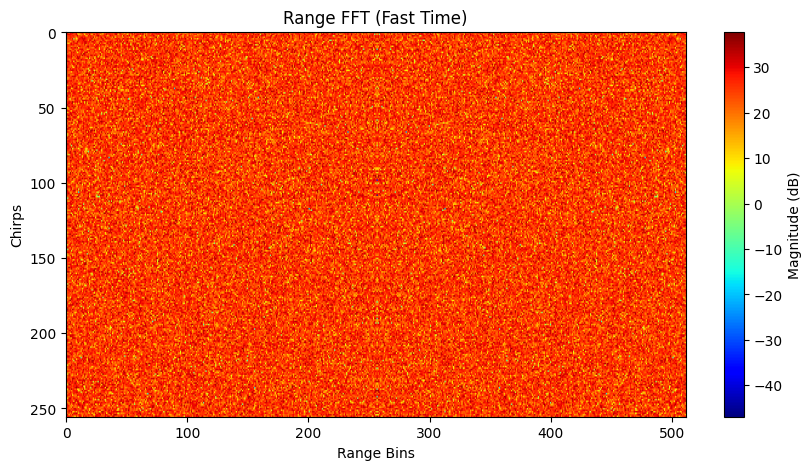

Optimal range-bin: (np.int64(47), np.int64(57))


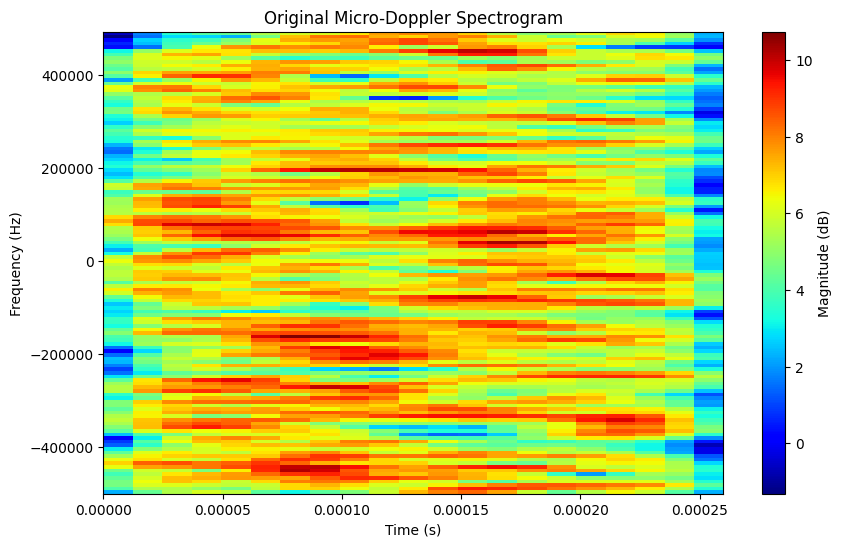

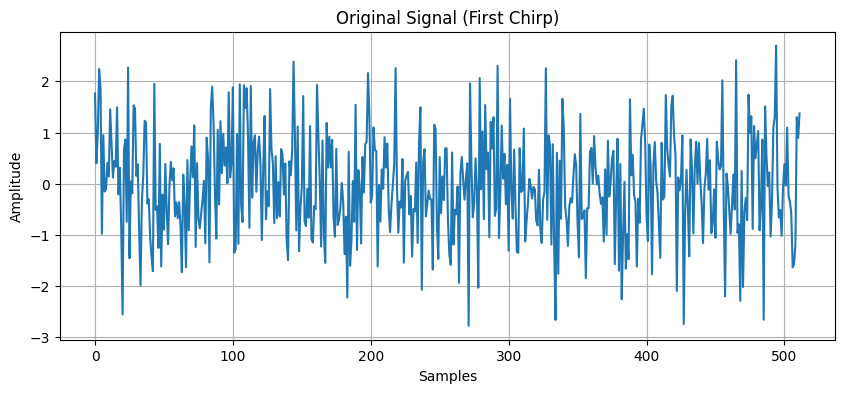

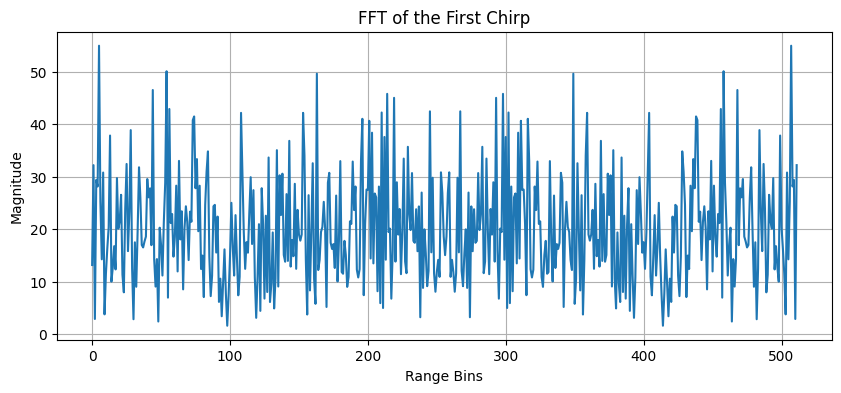

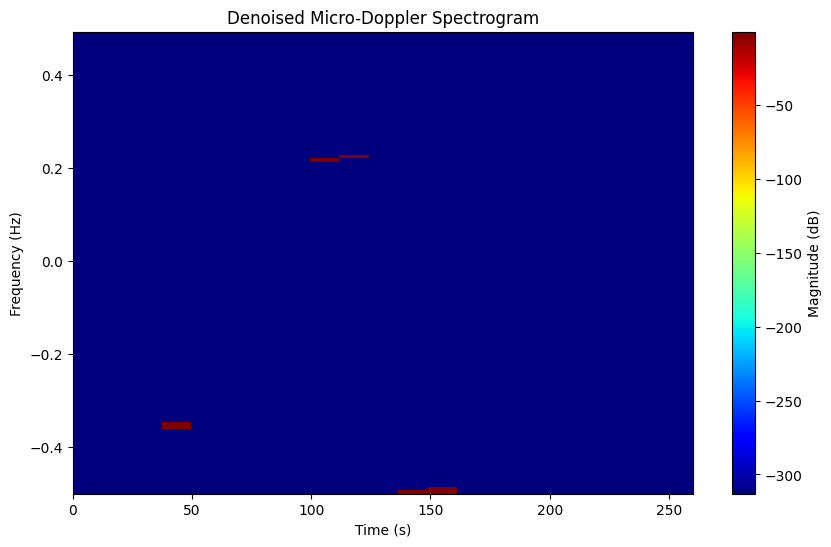

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy import signal

# ---------------------------
# Algorithm 1: Optimal Range-Bin Determination
# ---------------------------
def compute_full_fft(signal_data):
    """
    Compute Range FFT (fast-time) and visualize.
    """
    num_chirps, num_samples = signal_data.shape
    range_fft = np.fft.fft(signal_data, axis=1)
    range_fft_magnitude = np.abs(range_fft)

    plt.figure(figsize=(10, 5))
    plt.imshow(20*np.log10(range_fft_magnitude + np.finfo(float).eps),
               aspect='auto', cmap='jet')
    plt.title("Range FFT (Fast Time)")
    plt.xlabel("Range Bins")
    plt.ylabel("Chirps")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

    return range_fft_magnitude

def compute_stft(signal_data, fs=1e6, window='hann'):
    """
    Compute STFT for a 1D signal.
    """
    f, t, Zxx = stft(signal_data, fs=fs, window=window, return_onesided=False)
    Zxx_db = 10 * np.log10(np.abs(Zxx) + np.finfo(float).eps)
    return f, t, Zxx, Zxx_db

def compute_entropy(Zxx, tau_index):
    """
    Compute Shannon entropy for a given time index.
    """
    mag = np.abs(Zxx[:, tau_index])
    P = mag / np.sum(mag)
    P = P[P > 0]  # avoid log(0)
    return -np.sum(P * np.log2(P))

def compute_average_entropy(Zxx, t):
    """
    Average entropy over time bins.
    """
    entropies = [compute_entropy(Zxx, i) for i in range(len(t))]
    return np.mean(entropies)

def algo1_process_range_bin(data_matrix, r_values):
    """
    Determine the optimal range bin by computing the STFT entropy
    over candidate range intervals.
    """
    num_chirps, num_samples = data_matrix.shape
    P_max = []

    # Compute full FFT and show plot.
    range_fft_mag = compute_full_fft(data_matrix)

    # For each chirp, get the maximum FFT magnitude (note: here we use the value, not index)
    for i in range(num_chirps):
        P_max.append(np.max(range_fft_mag[i, :]))

    # Use the most frequent maximum value (cast to int)
    idx_max = np.argmax(np.bincount(np.array(P_max, dtype=int)))

    min_entropy = float('inf')
    best_r_opt = None

    for r_val in r_values:
        # Define a candidate window around idx_max (ensuring valid indices)
        start_idx = max(0, idx_max - r_val)
        end_idx = min(num_samples, idx_max + r_val)
        r_q = np.arange(start_idx, end_idx)

        # Compute average STFT entropy for this window (averaging over all chirps)
        entropies = []
        for i in range(num_chirps):
            seg = data_matrix[i, r_q]
            f, t, Zxx, _ = compute_stft(seg)
            entropies.append(compute_average_entropy(Zxx, t))
        overall_entropy = np.mean(entropies)

        if overall_entropy < min_entropy:
            min_entropy = overall_entropy
            best_r_opt = r_q

    optimal_range_bin = (best_r_opt[0], best_r_opt[-1] + 1)  # end is non-inclusive
    return optimal_range_bin

# ---------------------------
# Original Micro-Doppler Spectrogram
# ---------------------------
def compute_micro_doppler_spectrogram(data_matrix, optimal_range, nperseg=128, fs=1e6, window='hann'):
    """
    Compute the micro-Doppler spectrogram from the original data.
    Steps:
      1. Compute Range FFT for all chirps.
      2. For the optimal range bins, compute the STFT of the slow-time signal.
      3. Average the STFT magnitudes over the range bins.
    """
    range_fft = np.fft.fft(data_matrix, axis=1)
    start, end = optimal_range
    selected_bins = np.arange(start, end)

    stft_sum = None
    count = 0
    for rb in selected_bins:
        slow_time_signal = range_fft[:, rb]
        nper = min(nperseg, len(slow_time_signal))
        noverlap = int(0.9 * nper)
        f, t, Zxx = stft(slow_time_signal, fs=fs, nperseg=nper, noverlap=noverlap, window=window)
        if stft_sum is None:
            stft_sum = np.abs(Zxx)
        else:
            stft_sum += np.abs(Zxx)
        count += 1

    stft_avg = stft_sum / count
    spectrogram_db = 20 * np.log10(stft_avg + np.finfo(float).eps)
    return f, t, spectrogram_db

def plot_spectrogram(f, t, spectrogram_db, title="Spectrogram", xlabel="Time (s)", ylabel="Frequency (Hz)"):
    """
    Plot a spectrogram.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram_db, aspect='auto',
               extent=[t.min(), t.max(), f.min(), f.max()],
               origin='lower', cmap='jet')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

# ---------------------------
# Modified Algorithm 2: Denoising via Adaptive STFT Thresholding
# ---------------------------
def algo2_denoise(data_matrix, optimal_range, Th=3):
    """
    Apply adaptive STFT thresholding to denoise the signal.
    Here, we process each selected range bin, threshold each STFT frame,
    and then average over the range bins.
    """
    num_chirps, num_samples = data_matrix.shape
    range_fft = np.fft.fft(data_matrix, axis=1)
    start, end = optimal_range
    selected_bins = np.arange(start, end)

    # Visualize the original signal and its FFT for the first chirp
    plt.figure(figsize=(10, 4))
    plt.plot(data_matrix[0, :])
    plt.title("Original Signal (First Chirp)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(np.abs(range_fft[0, :]))
    plt.title("FFT of the First Chirp")
    plt.xlabel("Range Bins")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

    denoised_list = []
    for rb in selected_bins:
        slow_time_signal = range_fft[:, rb]
        nper = min(128, len(slow_time_signal))
        noverlap = int(0.9 * nper)
        # Use a Gaussian window as in the paper
        f_rb, t_rb, Zxx = stft(slow_time_signal, nperseg=nper, noverlap=noverlap,
                               window=('gaussian', 14))
        # Adaptive thresholding on each time frame
        for i in range(Zxx.shape[1]):
            frame = Zxx[:, i].copy()
            mag = np.abs(frame)
            avg_mag = np.mean(mag)
            threshold = Th * avg_mag
            # If nearly all components are below threshold, consider reducing Th.
            mask = mag > threshold
            frame[~mask] = 0
            Zxx[:, i] = frame
        denoised_list.append(np.abs(Zxx))

    # Average the thresholded STFT magnitude over all selected range bins
    denoised_stft_avg = np.mean(np.stack(denoised_list, axis=0), axis=0)
    denoised_spectrogram_db = 20 * np.log10(denoised_stft_avg + np.finfo(float).eps)

    # Plot the denoised spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(denoised_spectrogram_db, aspect='auto',
               extent=[t_rb.min(), t_rb.max(), f_rb.min(), f_rb.max()],
               origin='lower', cmap='jet')
    plt.title("Denoised Micro-Doppler Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

    return f_rb, t_rb, denoised_spectrogram_db

# ---------------------------
# Main Processing
# ---------------------------
# Example usage:
# (Replace the following with your actual data.)
# For instance, your 24 GHz FMCW simulated data with a walking person:
# data_matrix = np.load('your_data.npy')
# r_values = [5, 10, 20, 30]  # candidate range intervals

# For demonstration, we create a dummy dataset.
np.random.seed(0)
data_matrix = np.random.randn(256, 512)  # Replace with your radar data
r_values = [5, 10, 20, 30]

# Determine the optimal range-bin (Algorithm 1)
optimal_range_bin = algo1_process_range_bin(data_matrix, r_values)
print("Optimal range-bin:", optimal_range_bin)

# (A) Compute and plot the original micro-Doppler spectrogram
f_orig, t_orig, orig_spec_db = compute_micro_doppler_spectrogram(data_matrix, optimal_range_bin,
                                                                 nperseg=128, fs=1e6, window='hann')
plot_spectrogram(f_orig, t_orig, orig_spec_db,
                 title="Original Micro-Doppler Spectrogram",
                 xlabel="Time (s)", ylabel="Frequency (Hz)")

# (B) Compute and plot the denoised micro-Doppler spectrogram (Algorithm 2)
# If the output appears too flat (i.e. almost 0 dB everywhere), consider lowering Th (e.g., to 1 or 2)
f_den, t_den, den_spec_db = algo2_denoise(data_matrix, optimal_range_bin, Th=3)


Optimal range bin interval: (np.int64(5), np.int64(12))
Peak range bin: 50


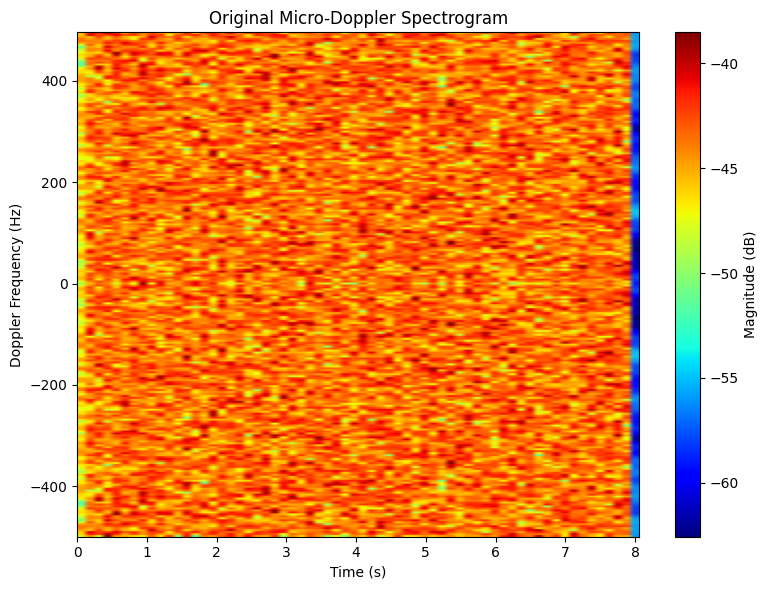

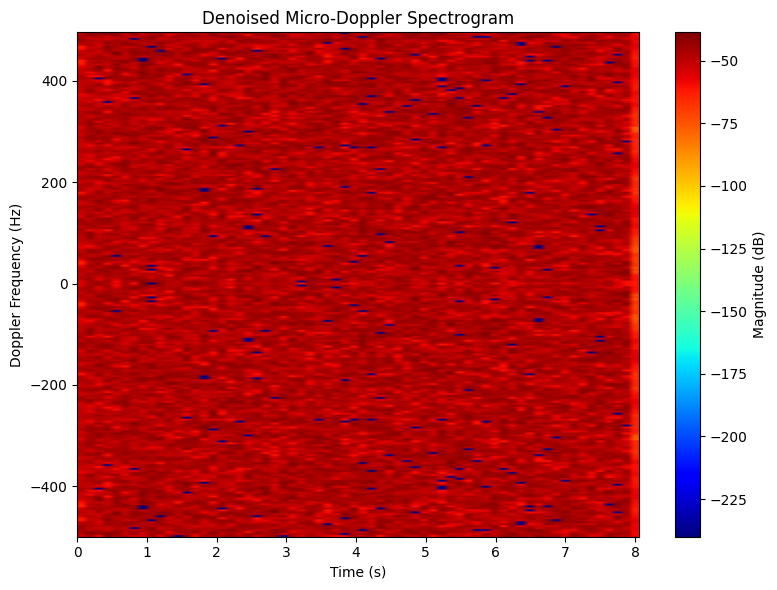

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
#from scipy.io import loadmat  # if needed

# ---------------------------
# 1. (Optional) Remove Slow-Time DC (clutter) for each range bin
# ---------------------------
def remove_dc_slow_time(data_matrix):
    """
    data_matrix shape: (num_chirps, num_range_bins)
    Subtract the mean across chirps (axis=0) for each range bin
    to remove strong static/clutter components.
    """
    return data_matrix - np.mean(data_matrix, axis=0, keepdims=True)

# ---------------------------
# 2. Shannon Entropy of STFT
# ---------------------------
def compute_entropy(Zxx):
    """
    Compute average Shannon entropy over all time frames in Zxx.
    Zxx shape: (freq_bins, time_frames)
    """
    entropies = []
    for i in range(Zxx.shape[1]):
        spec = np.abs(Zxx[:, i])
        s = np.sum(spec)
        if s < 1e-12:
            entropies.append(0)
            continue
        p = spec / s
        p = p[p > 0]
        ent = -np.sum(p * np.log2(p))
        entropies.append(ent)
    return np.mean(entropies)

# ---------------------------
# 3. Optimal Range-Bin Selection
# ---------------------------
def optimal_range_bin_selection(data_matrix, r_values, fs_slow, nperseg=256, noverlap=128, window='hann'):
    """
    data_matrix shape: (num_chirps, num_range_bins)
    1) Find the range bin with max average amplitude.
    2) For each candidate ±r around that bin, compute STFT entropy.
    3) Return the interval with the lowest average entropy.
    """
    # Range profile: average magnitude across chirps
    range_profile = np.mean(np.abs(data_matrix), axis=0)
    idx_max = np.argmax(range_profile)

    best_entropy = np.inf
    best_interval = (idx_max, idx_max+1)

    for r in r_values:
        start = max(0, idx_max - r)
        end = min(data_matrix.shape[1], idx_max + r + 1)
        # Compute STFT entropy across all bins in [start, end)
        # Then average.
        ent_list = []
        for bin_idx in range(start, end):
            slow_time_signal = data_matrix[:, bin_idx]
            f, t, Zxx = stft(slow_time_signal, fs=fs_slow, nperseg=nperseg,
                             noverlap=noverlap, window=window, return_onesided=False)
            ent_list.append(compute_entropy(Zxx))
        avg_ent = np.mean(ent_list)
        if avg_ent < best_entropy:
            best_entropy = avg_ent
            best_interval = (start, end)

    return best_interval, idx_max

# ---------------------------
# 4. Compute and Plot Micro-Doppler Spectrogram
# ---------------------------
def compute_micro_doppler_spectrogram(data_matrix, rng_interval, fs_slow,
                                      nperseg=256, noverlap=128, window='hann'):
    """
    data_matrix shape: (num_chirps, num_range_bins)
    rng_interval: (start, end) for range bins
    Return freq bins, time bins, and dB spectrogram averaged over range bins.
    """
    start, end = rng_interval
    accum = None
    count = 0
    for bin_idx in range(start, end):
        slow_time_signal = data_matrix[:, bin_idx]
        f, t, Zxx = stft(slow_time_signal, fs=fs_slow, nperseg=nperseg,
                         noverlap=noverlap, window=window, return_onesided=False)
        mag = np.abs(Zxx)
        if accum is None:
            accum = mag
        else:
            accum += mag
        count += 1
    avg_mag = accum / count
    spec_db = 20*np.log10(avg_mag + 1e-12)
    return f, t, spec_db

def plot_spectrogram(f, t, spec_db, title="Spectrogram"):
    plt.figure(figsize=(8,6))
    plt.imshow(spec_db, origin='lower', aspect='auto',
               extent=[t.min(), t.max(), f.min(), f.max()],
               cmap='jet')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Doppler Frequency (Hz)")
    plt.colorbar(label="Magnitude (dB)")
    plt.tight_layout()
    plt.show()

# ---------------------------
# 5. Denoising (Adaptive Threshold)
# ---------------------------
def denoise_micro_doppler_spectrogram(data_matrix, rng_interval, fs_slow,
                                      Th=1.0, nperseg=256, noverlap=128, window='hann'):
    """
    For each bin in rng_interval, compute STFT, apply threshold on each time frame,
    then average the magnitudes.
    Th is the factor for the adaptive threshold = Th * mean_magnitude_of_frame
    """
    start, end = rng_interval
    accum = None
    count = 0
    for bin_idx in range(start, end):
        slow_time_signal = data_matrix[:, bin_idx]
        f, t, Zxx = stft(slow_time_signal, fs=fs_slow, nperseg=nperseg,
                         noverlap=noverlap, window=window, return_onesided=False)
        # Threshold each time frame:
        for i in range(Zxx.shape[1]):
            frame = Zxx[:, i]
            mag_frame = np.abs(frame)
            mean_mag = np.mean(mag_frame)
            threshold = Th * mean_mag
            frame[mag_frame < threshold] = 0
            Zxx[:, i] = frame
        mag_denoised = np.abs(Zxx)
        if accum is None:
            accum = mag_denoised
        else:
            accum += mag_denoised
        count += 1
    avg_mag = accum / count
    spec_db = 20*np.log10(avg_mag + 1e-12)
    return f, t, spec_db

# ---------------------------
# Main demonstration
# ---------------------------
if __name__ == "__main__":
    # ================
    # (A) Load or simulate your data
    # ================
    # Example: Suppose your .mat file has a variable with shape (102, 8000):
    #   102 range bins, 8000 chirps
    # Then we transpose so that we have (8000, 102).
    #
    # from scipy.io import loadmat
    # mat_data = loadmat('3m_O_file1.mat')  # or whichever file
    # raw_data = mat_data['received_time_domain_signal']  # or the correct variable name
    # # Now raw_data might be shape (102, 8000).
    # data_matrix = raw_data.T  # shape (8000, 102)
    #
    # For demonstration, let's simulate random data + a small sinusoid:
    np.random.seed(0)
    num_range_bins = 102
    num_chirps = 8000
    raw_data = 0.1*np.random.randn(num_range_bins, num_chirps)
    # Insert a small sinusoid around bin 50 to simulate a target
    for c in range(num_chirps):
        raw_data[50, c] += 0.5*np.cos(2*np.pi*2*(c/1000.0))  # 2 Hz doppler
    data_matrix = raw_data.T  # shape (8000, 102)

    # ================
    # (B) Remove DC/clutter in slow-time (optional but often helps)
    # ================
    data_matrix = remove_dc_slow_time(data_matrix)

    # ================
    # (C) Set slow-time sampling rate
    # ================
    # If each chirp is 1 ms => 1000 Hz. If you have 8000 chirps over 8s => 1000 Hz.
    fs_slow = 1000.0

    # ================
    # (D) Determine optimal range bin interval
    # ================
    r_values = [1, 2, 3, 4, 5]  # half-widths to test
    rng_interval, idx_peak = optimal_range_bin_selection(data_matrix, r_values, fs_slow,
                                                         nperseg=256, noverlap=128, window='hann')
    rng_interval=(np.int64(5), np.int64(12))
    print("Optimal range bin interval:", rng_interval)
    print("Peak range bin:", idx_peak)

    # ================
    # (E) Original Micro-Doppler Spectrogram
    # ================
    f_orig, t_orig, spec_orig_db = compute_micro_doppler_spectrogram(data_matrix, rng_interval, fs_slow,
                                                                     nperseg=256, noverlap=128, window='hann')
    plot_spectrogram(f_orig, t_orig, spec_orig_db, title="Original Micro-Doppler Spectrogram")

    # ================
    # (F) Denoised Micro-Doppler Spectrogram
    # ================
    # If you see too many black/blue “zeros,” reduce Th to e.g. 0.5 or 0.2.
    f_den, t_den, spec_den_db = denoise_micro_doppler_spectrogram(data_matrix, rng_interval, fs_slow,
                                                                  Th=1.0, nperseg=256, noverlap=128, window='hann')
    plot_spectrogram(f_den, t_den, spec_den_db, title="Denoised Micro-Doppler Spectrogram")
